In [1]:
import os
import sys
import torch
import pandas as pd

sys.path.append('/home/fboehning/fboehning')

import logging
logging.basicConfig(
    level=logging.INFO,
    #level=logging.DEBUG,
    format='%(asctime)s - %(filename)s - %(name)s - %(funcName)s - %(levelname)s - %(message)s')

In [17]:
import importlib

import beesup_llm; importlib.reload(beesup_llm)
import beesup_llm.toolkit.setup_utils; importlib.reload(beesup_llm.toolkit.setup_utils); from beesup_llm.toolkit.setup_utils import *
import beesup_llm.toolkit.visualization; importlib.reload(beesup_llm.toolkit.visualization); from beesup_llm.toolkit.visualization import *
import beesup_llm.toolkit.display_settings; importlib.reload(beesup_llm.toolkit.display_settings); from beesup_llm.toolkit.display_settings import *

import beesup_llm.model; importlib.reload(beesup_llm.model); from beesup_llm.model import *
import beesup_llm.dataset; importlib.reload(beesup_llm.dataset); from beesup_llm.dataset import *

import beesup_llm.taxomizing; importlib.reload(beesup_llm.taxomizing); from beesup_llm.taxomizing import *
import beesup_llm.taxomizing.taxomizing_utils; importlib.reload(beesup_llm.taxomizing.taxomizing_utils); from beesup_llm.taxomizing.taxomizing_utils import *


#import beesup_llm.training; importlib.reload(beesup_llm.training); from beesup_llm.training import *
#import beesup_llm.inference; importlib.reload(beesup_llm.inference); from beesup_llm.inference import *
#import beesup_llm.evaluation; importlib.reload(beesup_llm.evaluation); from beesup_llm.evaluation import *

# Test Embedding Models

In [3]:
!nvidia-smi

Wed Nov 27 07:13:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:D5:00.0 Off |                    0 |
|  0%   33C    P8             33W /  300W |       4MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
modelwrap=NvidiaModelWrap(
    encode_config=dict(
        instruction="Instruct: Retrieve the a suitable header for the chunk.\nChunk: "
        )
    )
modelwrap.get_config()

2024-11-26 14:42:50,452 - __init__.py - beesup_llm - __init__ - INFO - 0005_EMB_MODEL initialised


{'type': 'emb_model',
 'id': 5,
 'name': '0005_emb_model',
 'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'name_or_path': 'nvidia/NV-Embed-v2',
 'encode_config': {'instruction': 'Instruct: Retrieve the a suitable header for the chunk.\nChunk: ',
  'max_length': 32768},
 'timestamp_init': '2024-11-26_15-42-50',
 'bnb_config': {'load_in_4bit': True,
  'bnb_4bit_use_double_quant': True,
  'bnb_4bit_quant_type': 'nf4'},
 'model_load_config': {'trust_remote_code': True}}

In [19]:
modelwrap=JinaaiModelWrap(task='text-matching')
modelwrap.get_config()

2024-11-26 14:34:46,540 - __init__.py - beesup_llm - __init__ - INFO - 0005_EMB_MODEL initialised


{'type': 'emb_model',
 'id': 5,
 'name': '0005_emb_model',
 'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'name_or_path': 'jinaai/jina-embeddings-v3',
 'task': 'text-matching',
 'timestamp_init': '2024-11-26_15-34-46',
 'bnb_config': {'load_in_4bit': True,
  'bnb_4bit_use_double_quant': True,
  'bnb_4bit_quant_type': 'nf4'},
 'model_load_config': {'trust_remote_code': True,
  'device_map': 'auto',
  'use_flash_attn': False,
  'task': 'separation'},
 'encode_config': {}}

# Generate Knowledge Dataset

In [5]:
import re
import sqlite3
import spacy

nlp=spacy.load('de_core_news_sm')

def count_words(text):
    text=re.sub(r'[(),-;]','',text) #normaly parentheses, commas and hyphens are counted as words --> remove them
    doc=nlp(text)
    return len(doc)

In [6]:
conn = sqlite3.connect('wildbienen_db.db')
query = """
WITH InfoQuery AS (
    -- First query (retrieving scientific names and associated attrs)
    SELECT
        t.name AS genus_species,
        ta.name AS author_year,
        it.name AS attr_key,
        i.value AS attr_val,
		s.name AS source_name,
		--s.base_url AS source_url,
		--i.source_other,
		it.type AS attr_type
		
	FROM information i	
    JOIN taxa t ON i.taxon_id = t.id
    JOIN info_types it ON i.type_id = it.id
    JOIN taxon_authors ta ON t.author_id = ta.id
    LEFT JOIN sources s ON i.source_id = s.id
	WHERE attr_key NOT IN (
		'Literatur', 'Literatur und Quellen', 'Quellen', 'Siehe auch', 'Belege', 
		'Weblinks', 'Weblink', 'Webseite', 'Einzelnachweise', 
		'Rote Liste BW:', 'Rote Liste D:',
		'Bilder', 'Bildergalerie',
		'Videos', 'Videoclips'
		)
		--AND genus_species in ('Andrena nitida', 'Andrena flavipes', 'Andrena nitidiuscula')
),

VernacularNames AS (
    -- Second query (retrieving vernacular names for German and English where the scientific name matches InfoQuery)
    SELECT
        t.name AS genus_species,
        ta.name AS author_year,
        'Deutscher Name:' AS attr_key,
        tv.name AS attr_val,
        'wildbienen-kataster' AS source_name,           
		'Attribute' AS attr_type

		
    FROM taxa t
    JOIN taxon_vernacularnames tv ON t.id = tv.taxon_id
    JOIN taxon_authors ta ON t.author_id = ta.id
    WHERE tv.language_code = 'de'
    AND t.name IN (SELECT genus_species FROM InfoQuery)

)

-- Final query to combine InfoQuery and VernacularNames
SELECT * FROM InfoQuery

UNION

SELECT * FROM VernacularNames

ORDER BY genus_species, attr_key, attr_val;

"""

query_df = pd.read_sql_query(query, conn)
conn.close()


query_df['attr_key']=query_df['attr_key'].apply(lambda x: re.sub(r': *$', '', x))
query_df['attr_val']=query_df['attr_val'].apply(lambda x: x.strip())

query_df['author_year']=query_df['author_year'].apply(lambda x: re.sub(r'[()]', '', x))
query_df['attr_val']=query_df.apply(lambda x: f'{x.genus_species} ({x.author_year})' if x.attr_key=='Wissenschaftlicher Name' else x.attr_val, axis=1)

query_df.replace('', np.nan, inplace=True)
query_df.dropna(inplace=True)

query_df.loc[query_df.attr_key=='Deutscher Name','attr_key']='Umgangssprachliche Bezeichnungen'
query_df.loc[query_df.attr_key=='Kuckucksbiene','attr_key']='Kuckucksbienen'
query_df.loc[query_df.attr_key=='Kuckuckswespe','attr_key']='Kuckuckswespen'
query_df.loc[query_df.attr_key=='Wirtsbiene','attr_key']='Wirtsbienen'

query_df=query_df[query_df.attr_val!='']
#query_df['n_tokns']=query_df['attr_val'].apply(lambda x: len(tokenizer.encode(x)))

query_df

,genus_species,author_year,attr_key,attr_val,source_name,attr_type
0,Aglaoapis tridentata,"Nylander, 1848",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text
1,Aglaoapis tridentata,"Nylander, 1848",Umgangssprachliche Bezeichnungen,Dunkle Zweizahnbiene,wildbienen-kataster,Attribute
2,Aglaoapis tridentata,"Nylander, 1848",Umgangssprachliche Bezeichnungen,Zweizahnbiene,wildbienen-kataster,Attribute
3,Aglaoapis tridentata,"Nylander, 1848",Familie,Megachilidae,wildbienen-kataster,Attribute
4,Aglaoapis tridentata,"Nylander, 1848",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text
...,...,...,...,...,...,...
4301,Xylocopa violacea,"Linnaeus, 1758",Nistweise,hypergäisch-selbstgegrabene Hohlräume,wildbienen-kataster,Attribute
4302,Xylocopa violacea,"Linnaeus, 1758",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute
4303,Xylocopa violacea,"Linnaeus, 1758",Requisiten,Totholz,wildbienen-kataster,Attribute
4304,Xylocopa violacea,"Linnaeus, 1758",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text


In [7]:
knowledge_df=query_df.groupby(by=['genus_species','author_year','attr_key']).agg({
    'attr_val': lambda x: '; '.join(x),
    'source_name': lambda x: x.iloc[0],
    'attr_type': lambda x: x.iloc[0],
    #'n_tokns':'sum',

}).reset_index()

knowledge_df['n_units']=query_df.groupby(by=['genus_species','author_year','attr_key']).size().values
knowledge_df['n_words']=knowledge_df['attr_val'].apply(count_words)

knowledge_df['scientific_name']=knowledge_df['genus_species']+' ('+knowledge_df['author_year']+')'

knowledge_df

,genus_species,author_year,attr_key,attr_val,source_name,attr_type,n_units,n_words,scientific_name
0,Aglaoapis tridentata,"Nylander, 1848",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"Aglaoapis tridentata (Nylander, 1848)"
1,Aglaoapis tridentata,"Nylander, 1848",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"Aglaoapis tridentata (Nylander, 1848)"
2,Aglaoapis tridentata,"Nylander, 1848",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,"Aglaoapis tridentata (Nylander, 1848)"
3,Aglaoapis tridentata,"Nylander, 1848",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,"Aglaoapis tridentata (Nylander, 1848)"
4,Aglaoapis tridentata,"Nylander, 1848",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,"Aglaoapis tridentata (Nylander, 1848)"
...,...,...,...,...,...,...,...,...,...
3884,Xylocopa violacea,"Linnaeus, 1758",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)"
3885,Xylocopa violacea,"Linnaeus, 1758",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)"
3886,Xylocopa violacea,"Linnaeus, 1758",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4,"Xylocopa violacea (Linnaeus, 1758)"
3887,Xylocopa violacea,"Linnaeus, 1758",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text,1,162,"Xylocopa violacea (Linnaeus, 1758)"


In [21]:
knowledge_df.drop(columns=['prompt','gold_completion','prompt_messages','gold_message'],inplace=True)

In [22]:
knowledge_ds=BaseDataset()
knowledge_ds.get_config()

2024-11-06 07:37:37,059 - __init__.py - beesup_llm - __init__ - INFO - 0001_DATASET initialised


{'type': 'dataset',
 'id': 1,
 'name': '0001_dataset',
 'path': '/home/fboehning/fboehning/cluster_lab/datasets/0001_dataset',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/datasets',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'datetime_init': datetime.datetime(2024, 11, 6, 8, 37, 37, 58916, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>)}

In [23]:
ds_config=dict(
    remarks = 'basic knowledge_df from wildbienen_db, no embeddings',
)
knowledge_ds.dataset_df=knowledge_df
knowledge_ds.update_attributes(ds_config)
knowledge_ds.get_config()

{'type': 'dataset',
 'id': 1,
 'name': '0001_dataset',
 'path': '/home/fboehning/fboehning/cluster_lab/datasets/0001_dataset',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/datasets',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'datetime_init': datetime.datetime(2024, 11, 6, 8, 37, 37, 58916, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>),
 'remarks': 'basic knowledge_df from wildbienen_db, no embeddings'}

In [24]:
knowledge_ds.dataset_df

,genus_species,author_year,attr_key,attr_val,source_name,attr_type,n_units,n_words,scientific_name
0,Aglaoapis tridentata,"Nylander, 1848",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"Aglaoapis tridentata (Nylander, 1848)"
1,Aglaoapis tridentata,"Nylander, 1848",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"Aglaoapis tridentata (Nylander, 1848)"
2,Aglaoapis tridentata,"Nylander, 1848",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,"Aglaoapis tridentata (Nylander, 1848)"
3,Aglaoapis tridentata,"Nylander, 1848",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,"Aglaoapis tridentata (Nylander, 1848)"
4,Aglaoapis tridentata,"Nylander, 1848",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,"Aglaoapis tridentata (Nylander, 1848)"
...,...,...,...,...,...,...,...,...,...
3884,Xylocopa violacea,"Linnaeus, 1758",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)"
3885,Xylocopa violacea,"Linnaeus, 1758",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)"
3886,Xylocopa violacea,"Linnaeus, 1758",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4,"Xylocopa violacea (Linnaeus, 1758)"
3887,Xylocopa violacea,"Linnaeus, 1758",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text,1,162,"Xylocopa violacea (Linnaeus, 1758)"


In [25]:
knowledge_ds.spawn()

2024-11-06 07:38:08,249 - __init__.py - root - spawn - INFO - 0001_DATASET spawned at /home/fboehning/fboehning/cluster_lab/datasets/0001_dataset


# Generate Embedding Dataset

In [3]:
knowledge_ds = BaseDataset(1)
knowledge_df=knowledge_ds.dataset_df
knowledge_df

knowledge_df=knowledge_ds.dataset_df.copy()
knowledge_df=knowledge_df.drop(columns=['genus_species','author_year'])
knowledge_df=knowledge_df.rename(columns={
    'scientific_name':'s',
    'attr_key':'p',
    'attr_val':'o',
})
col_order=['s','p','o','source_name','attr_type','n_units','n_words']
knowledge_df=knowledge_df[col_order]

knowledge_df

2024-11-26 15:19:24,908 - __init__.py - beesup_llm - __init__ - INFO - 0001_DATASET initialised


,s,p,o,source_name,attr_type,n_units,n_words
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1
2,"Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23
3,"Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38
4,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1
...,...,...,...,...,...,...,...
3884,"Xylocopa violacea (Linnaeus, 1758)",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1
3885,"Xylocopa violacea (Linnaeus, 1758)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1
3886,"Xylocopa violacea (Linnaeus, 1758)",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4
3887,"Xylocopa violacea (Linnaeus, 1758)",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text,1,162


In [4]:
modelwrap=EmbModelWrap.from_ref(5)
modelwrap.get_config()

2024-11-26 15:19:24,964 - __init__.py - beesup_llm - __init__ - INFO - 0005_EMB_MODEL initialised


{'type': 'emb_model',
 'id': 5,
 'name': '0005_emb_model',
 'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'name_or_path': 'nvidia/NV-Embed-v2',
 'encode_config': {'instruction': 'Instruct: Retrieve the a suitable header for the chunk.\nChunk: ',
  'max_length': 32768},
 'timestamp_init': '2024-11-26_15-42-50',
 'bnb_config': {'load_in_4bit': True,
  'bnb_4bit_use_double_quant': True,
  'bnb_4bit_quant_type': 'nf4'},
 'model_load_config': {'trust_remote_code': True}}

In [5]:
modelwrap.load_model()

2024-11-26 15:19:24,990 - __init__.py - beesup_llm - load_model - INFO - Loading model nvidia/NV-Embed-v2
2024-11-26 15:19:26,475 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Nov 26 15:15:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:D5:00.0 Off |                    0 |
|  0%   51C    P0            115W /  300W |   26141MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
torch.cuda.empty_cache()

In [ ]:
embs=modelwrap.unique_encode(knowledge_df["s"].values.tolist(), batch_size=128)
embs

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 GiB. GPU 

In [6]:
EMB_TEMPLATES={
    "s":"{s}",
    "p":"{p}",
    "o":"{o}",
    "spo":"{s}\n{p}\n{o}",
    "po":"{p}\n{o}",
    "so":"{s}\n{o}",
}

for key in EMB_TEMPLATES.keys():
    print(f'{key}' + 20*' ', end='\r')
    if key not in knowledge_df.columns:
        knowledge_df[key]=knowledge_df.apply(lambda x:EMB_TEMPLATES[key].format(**x),axis=1)

    knowledge_df[f'{key}_emb'] = list(modelwrap.unique_encode(knowledge_df[key].values, batch_size=32))

    #knowledge_df.to_pickle(f'knowledge_embs_{key.lower()}.pkl')
#mit nvidia model ca. 20 min

/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


/home/fboehning/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [7]:
knowledge_df.to_pickle(f'26knowledge_embs_df.pkl')

In [23]:
knowledge_df

,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,spo,spo_emb,po,po_emb,so,so_emb
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.028337106, -0.15658651, 0.046521347, 0.0495...","[-0.009929027, -0.11381302, 0.036996722, 0.022...","Aglaoapis tridentata (Nylander, 1848)\nAussehe...","[-0.0066839936, -0.14341907, 0.058438372, -0.0...","Aussehen\nDie Biene ist schwarz, etwa 8–10 mm ...","[-0.014219728, -0.11722384, 0.033901803, 0.023...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[-0.0052869027, -0.14025068, 0.060333725, -0.0..."
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.012890901, -0.13888489, 0.078900084, 0.0967...","[0.037681438, -0.089606725, 0.09899471, 0.0287...","Aglaoapis tridentata (Nylander, 1848)\nFamilie...","[0.027594993, -0.13882783, 0.08743935, 0.00307...",Familie\nMegachilidae,"[0.037294433, -0.096607715, 0.10106653, 0.0263...","Aglaoapis tridentata (Nylander, 1848)\nMegachi...","[0.0263393, -0.1419707, 0.07908974, 0.01106930..."
2,"Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.072593026, -0.14056718, 0.067512274, 0.0997...","[-0.017724864, -0.13271707, 0.01765698, 0.0059...","Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","[0.0009394387, -0.13168092, 0.04240996, 0.0146...",Kurzbeschreibung\nDunkle Zweizahnbiene (Aglaoa...,"[-0.015158053, -0.13689616, 0.019908909, 0.011...","Aglaoapis tridentata (Nylander, 1848)\nDunkle ...","[0.0007432551, -0.13645758, 0.040096294, 0.008..."
3,"Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.018902762, -0.11808972, 0.09573773, 0.02170...","[-0.04876071, -0.13665177, 0.008985177, -0.036...","Aglaoapis tridentata (Nylander, 1848)\nLebensr...","[-0.0183638, -0.14735551, 0.05069998, -0.03031...","Lebensraum\nDie Biene lebt auf trockenen, blüt...","[-0.05213058, -0.12946388, 0.01576855, -0.0287...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[-0.016963052, -0.14869441, 0.05155063, -0.037..."
4,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.043981124, -0.14862587, 0.06606647, 0.03241...","[0.06733126, -0.07728656, 0.06193564, 0.023729...","Aglaoapis tridentata (Nylander, 1848)\nSozialv...","[0.024878807, -0.12650661, 0.099095576, -0.018...",Sozialverhalten\nparasitisch,"[0.05508868, -0.12667683, 0.08146612, 0.005561...","Aglaoapis tridentata (Nylander, 1848)\nparasit...","[0.03187982, -0.10262307, 0.05641737, -0.02599..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,"Xylocopa violacea (Linnaeus, 1758)",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,"[-0.008919053, -0.051392507, 0.03929232, 0.041...","[-0.02611837, -0.12151797, 0.047519922, 0.0106...","[0.10485395, -0.12317868, 0.11367416, 0.050754...","Xylocopa violacea (Linnaeus, 1758)\nPollensamm...","[-0.023617474, -0.087996215, 0.048257727, 0.02...",Pollensammelverhalten\npolylektisch,"[-0.0010424226, -0.120506234, 0.064706616, 0.0...","Xylocopa violacea (Linnaeus, 1758)\npolylektisch","[0.008595075, -0.053012256, 0.04369797, 0.0362..."
3885,"Xylocopa violacea (Linnaeus, 1758)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"[-0.008919053, -0.051392507, 0.03929232, 0.041...","[0.108293615, -0.091345385, 0.121899925, 0.116...","[0.07173592, -0.09060178, 0.050473787, 0.03776...","Xylocopa violacea (Linnaeus, 1758)\nRequisiten...","[0.028948791, -0.07495989, 0.059621245, 0.0197...",Requisiten\nTotholz,"[0.08685386, -0.08680512, 0.092410

In [8]:
dataset=BaseDataset(emb_model_ref=modelwrap, parent_ref=knowledge_ds)
dataset.get_config()

2024-11-26 15:41:51,191 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised
2024-11-26 15:41:51,193 - __init__.py - beesup_llm - __init__ - INFO - 0005_EMB_MODEL initialised
2024-11-26 15:41:51,194 - __init__.py - beesup_llm - __init__ - INFO - 0001_DATASET initialised


{'type': 'dataset',
 'id': 6,
 'name': '0006_dataset',
 'path': '/home/fboehning/fboehning/cluster_lab/datasets/0006_dataset',
 'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/datasets',
 'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
 'timestamp_init': '2024-11-26_16-41-51',
 'emb_model_config': {'type': 'emb_model',
  'id': 5,
  'name': '0005_emb_model',
  'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
  'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
  'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
  'name_or_path': 'nvidia/NV-Embed-v2',
  'encode_config': {'instruction': 'Instruct: Retrieve the a suitable header for the chunk.\nChunk: ',
   'max_length': 32768},
  'timestamp_init': '2024-11-26_15-42-50',
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'model_load_config': {'trust_remote_code': True}},
 'parent_config': {'type': 'dat

In [9]:
dataset_config=dict(
    remarks='knowledge dataset with embeddings in subject, predicate and object variations',
)

dataset.dataset_df=knowledge_df
dataset.update_attributes(dataset_config)
dataset.spawn()

2024-11-26 15:42:04,041 - __init__.py - beesup_llm - spawn_config - INFO - 0006_DATASET config spawned at /home/fboehning/fboehning/cluster_lab/datasets/0006_dataset
2024-11-26 15:42:04,340 - __init__.py - root - spawn - INFO - 0006_DATASET spawned at /home/fboehning/fboehning/cluster_lab/datasets/0006_dataset


In [12]:
BaseDataset.get_overview(keypaths=['emb_model_config.name_or_path','emb_model_config.task'])

,path,id,name,emb_model_config.name_or_path,emb_model_config.task
0,/home/fboehning/fboehning/cluster_lab/datasets...,1,0001_dataset,NaN,NaN
1,/home/fboehning/fboehning/cluster_lab/datasets...,2,0002_dataset,jinaai/jina-embeddings-v3,separation
2,/home/fboehning/fboehning/cluster_lab/datasets...,3,0003_dataset,jinaai/jina-embeddings-v3,classification
3,/home/fboehning/fboehning/cluster_lab/datasets...,4,0004_dataset,jinaai/jina-embeddings-v3,retrieval.passage
4,/home/fboehning/fboehning/cluster_lab/datasets...,5,0005_dataset,jinaai/jina-embeddings-v3,text-matching
5,/home/fboehning/fboehning/cluster_lab/datasets...,6,0006_dataset,nvidia/NV-Embed-v2,NaN


In [82]:
dataset_2=BaseDataset(2).dataset_df
dataset_2.head(2)

2024-11-25 09:20:16,562 - __init__.py - beesup_llm - __init__ - INFO - 0002_DATASET initialised


,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,spo,spo_emb,po,po_emb,so,so_emb
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.028337106, -0.15658651, 0.046521347, 0.0495...","[-0.009929027, -0.11381302, 0.036996722, 0.022...","Aglaoapis tridentata (Nylander, 1848)\nAussehe...","[-0.0066839936, -0.14341907, 0.058438372, -0.0...","Aussehen\nDie Biene ist schwarz, etwa 8–10 mm ...","[-0.014219728, -0.11722384, 0.033901803, 0.023...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[-0.0052869027, -0.14025068, 0.060333725, -0.0..."
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"[0.018833343, -0.1258899, 0.07777834, -0.00079...","[0.012890901, -0.13888489, 0.078900084, 0.0967...","[0.037681438, -0.089606725, 0.09899471, 0.0287...","Aglaoapis tridentata (Nylander, 1848)\nFamilie...","[0.027594993, -0.13882783, 0.08743935, 0.00307...",Familie\nMegachilidae,"[0.037294433, -0.096607715, 0.10106653, 0.0263...","Aglaoapis tridentata (Nylander, 1848)\nMegachi...","[0.0263393, -0.1419707, 0.07908974, 0.01106930..."


In [83]:
dataset_3=BaseDataset(4).dataset_df
dataset_3.head(2)

2024-11-25 09:20:38,879 - __init__.py - beesup_llm - __init__ - INFO - 0004_DATASET initialised


,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,spo,spo_emb,po,po_emb,so,so_emb
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"[-0.026257742, -0.09255612, 0.073344134, -0.05...","[-0.019315539, -0.050794974, 0.015857194, 0.01...","[-0.07947062, -0.037709735, 0.028363574, -0.01...","Aglaoapis tridentata (Nylander, 1848)\nAussehe...","[-0.050797377, -0.074253336, 0.048811216, -0.0...","Aussehen\nDie Biene ist schwarz, etwa 8–10 mm ...","[-0.07948462, -0.036334988, 0.023403633, -0.02...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[-0.056704268, -0.07682941, 0.051095407, -0.05..."
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"[-0.026257742, -0.09255612, 0.073344134, -0.05...","[-0.010271967, -0.059279997, 0.06308424, 0.101...","[-0.008647576, 0.01120974, 0.079149544, -0.039...","Aglaoapis tridentata (Nylander, 1848)\nFamilie...","[-0.0063050585, -0.07694991, 0.08364312, -0.06...",Familie\nMegachilidae,"[-0.030868951, 0.006583269, 0.082108274, -0.03...","Aglaoapis tridentata (Nylander, 1848)\nMegachi...","[-0.00937917, -0.08301953, 0.085053526, -0.058..."


# Generate Multiway Tree

In [3]:
BaseDataset.get_overview(keypaths=['emb_model_config.task','remarks','emb_model_config.name_or_path'])

,path,id,name,remarks,task,name_or_path
0,/home/fboehning/fboehning/cluster_lab/datasets...,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN,NaN
1,/home/fboehning/fboehning/cluster_lab/datasets...,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",separation,jinaai/jina-embeddings-v3
2,/home/fboehning/fboehning/cluster_lab/datasets...,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",classification,jinaai/jina-embeddings-v3
3,/home/fboehning/fboehning/cluster_lab/datasets...,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",retrieval.passage,jinaai/jina-embeddings-v3
4,/home/fboehning/fboehning/cluster_lab/datasets...,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",text-matching,jinaai/jina-embeddings-v3
5,/home/fboehning/fboehning/cluster_lab/datasets...,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN,nvidia/NV-Embed-v2


In [4]:
knowledge_ds=BaseDataset(6)
knowledge_df=knowledge_ds.dataset_df

def get_first_n_words(text, n=2):
    return ' '.join(re.split(r'[\s,;]',text)[:n])

knowledge_df['label']=knowledge_df.apply(lambda x: f'{get_first_n_words(x.s)}/ {x.p}', axis=1)

def compose_emb(row):
    s,p,o,so,po,spo=[row[f'{c}_emb'] for c in ['s','p','o','so','po','spo']]

    if row.attr_type=='Text':
        emb=po
    elif row.attr_type=='Attribute':
        emb=po

    # weights = np.array([0.0, 0.25, 0.75]) 
    # emb = np.average(np.array([s,p,o]), axis=0, weights=weights)
    #emb=spo-s
    #emb=po

    emb_normalized=emb/ np.linalg.norm(emb) #normalize
    return emb_normalized

chunks_df=knowledge_df.copy()
chunks_df['emb']=knowledge_df.apply(compose_emb, axis=1)
chunks_df=chunks_df[['spo','s','p','o','source_name','attr_type','n_units','n_words','label','emb']].copy()
chunks_df['label']=chunks_df.apply(lambda x: f"{get_first_n_words(x.p, n=4)}/ {get_first_n_words(x.o, n=10)}", axis=1)

chunks_df.rename(columns={
    'spo':'chunk',
    's':'subject',
    'p':'predicate',
    'o':'object',
    },inplace=True)

#drop duplicates
chunks_df['emb_tuple']=chunks_df['emb'].apply(tuple)
chunks_df.drop_duplicates(subset='emb_tuple',keep='first',inplace=True)
chunks_df.drop(columns=['emb_tuple'],inplace=True)

chunks_df.reset_index(drop=True,inplace=True)
chunks_df

2024-12-02 14:08:39,196 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb
0,"Aglaoapis tridentata (Nylander, 1848)\nAussehe...","Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,Aussehen/ Die Biene ist schwarz etwa 8–10 mm ...,"[0.013315118, -0.0025690868, -0.002520601, -0...."
1,"Aglaoapis tridentata (Nylander, 1848)\nFamilie...","Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,Familie/ Megachilidae,"[-0.008217988, -0.017626682, 0.014735313, 0.00..."
2,"Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,Kurzbeschreibung/ Dunkle Zweizahnbiene (Aglaoa...,"[0.0050212676, -0.020270795, 0.03047962, -0.01..."
3,"Aglaoapis tridentata (Nylander, 1848)\nLebensr...","Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,Lebensraum/ Die Biene lebt auf trockenen blüt...,"[0.010719752, 0.007365582, 0.02396487, -0.0069..."
4,"Aglaoapis tridentata (Nylander, 1848)\nSozialv...","Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,Sozialverhalten/ parasitisch,"[0.0032968458, 0.008870961, 0.024923155, 0.009..."
...,...,...,...,...,...,...,...,...,...,...
2415,"Xylocopa violacea (Linnaeus, 1758)\nLebensweis...","Xylocopa violacea (Linnaeus, 1758)",Lebensweise,"Die Paarung erfolgt im Frühjahr, nachdem beide...",wikipedia,Text,1,173,Lebensweise/ Die Paarung erfolgt im Frühjahr ...,"[-0.000986353, -0.0118575245, 0.024509192, 0.0..."
2416,"Xylocopa violacea (Linnaeus, 1758)\nMerkmale\n...","Xylocopa violacea (Linnaeus, 1758)",Merkmale,Mit 20 bis 28 Millimeter Körperlänge zählen di...,wikipedia,Text,1,119,Merkmale/ Mit 20 bis 28 Millimeter Körperlänge...,"[0.013986376, 0.007970083, -0.004052453, -0.01..."
2417,"Xylocopa violacea (Linnaeus, 1758)\nUmgangsspr...","Xylocopa violacea (Linnaeus, 1758)",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4,Umgangssprachliche Bezeichnungen/ Blauschwarze...,"[0.02123162, 0.0107286265, 0.011301344, -0.010..."
2418,"Xylocopa violacea (Linnaeus, 1758)\nVorkommen\...","Xylocopa violacea (Linnaeus, 1758)",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text,1,162,Vorkommen/ Die Art kommt in Süd- und Mitteleur...,"[0.015496681, -0.0042675436, 0.02030104, -0.00..."


## Multiway Tree via Linkage

In [5]:
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(np.vstack(chunks_df['emb'].values))
distance_matrix = distance_matrix.astype(np.float64)
distance_matrix = squareform(distance_matrix, checks=False)

linkage_matrix = linkage(distance_matrix, method='ward', optimal_ordering=False)
#linkage_df = pd.DataFrame(linkage_matrix, columns=["left_child", "right_child", "dist", "size"])

2024-11-29 08:51:00,802 - 3959309158.py - root - get_dist_kneepoint - INFO - knee_dist: 1.0695, knee_index: 2382/ 2419


{'num_nodes': 4839, 'height': 27, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 6, 6, 6, 10, 14, 18, 28, 38, 51, 70, 103, 143, 199, 318, 512, 880]}


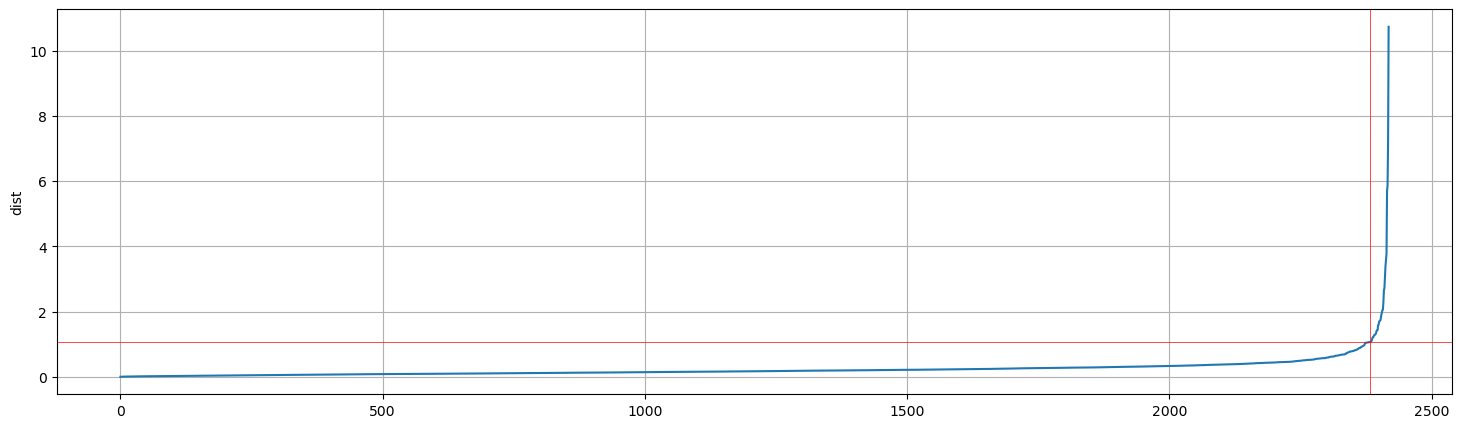

{'num_nodes': 2457, 'height': 9, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 2, 2, 4, 5, 8, 12]}


In [73]:
# DIST --> DDIST
tree=linkage_to_btree(linkage_matrix, chunks_df)
print(get_tree_info_dict(tree))

threshold_dist, index = get_dist_kneepoint(tree,  include_leaves=False, plot=True)
#threshold_dist, index = get_dist_std(tree, std_factor=1.0, include_leaves=False, plot=True)

tree=do_dist_flattening(tree, threshold_dist=threshold_dist)
print(get_tree_info_dict(tree))

2024-11-29 08:51:08,173 - 3135302064.py - root - get_ddist_kneepoint - INFO - knee_ddist: 0.9319, knee_index: 24/ 36


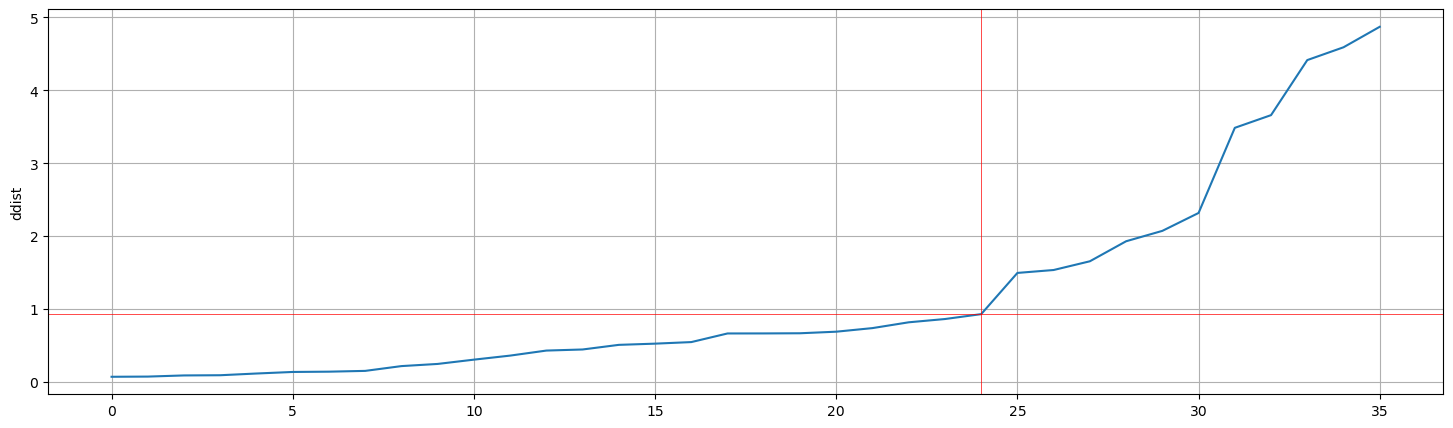

{'num_nodes': 2441, 'height': 6, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 3, 4, 10]}


In [74]:
#DDIST --> DIST
#tree=linkage_to_btree(linkage_matrix, chunks_df)
add_ddist(tree)

threshold_ddist, index = get_ddist_kneepoint(tree, include_leaves=False, plot=True)
#threshold_ddist, index = get_ddist_std(tree, std_factor=1.0, include_leaves=False, plot=True)

tree=do_ddist_flattening(tree, threshold_ddist=threshold_ddist)
print(get_tree_info_dict(tree))

In [85]:
logger = logging.getLogger('beesup_llm')
logger.setLevel(logging.DEBUG)

2024-12-02 14:09:11,807 - taxomizing_utils.py - root - get_dist_kneepoint - INFO - knee_dist: 1.0695, knee_index: 2382/ 2419


{'num_nodes': 4839, 'height': 27, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 1, 1, 1, 1, 1, 1, 2, 2]}


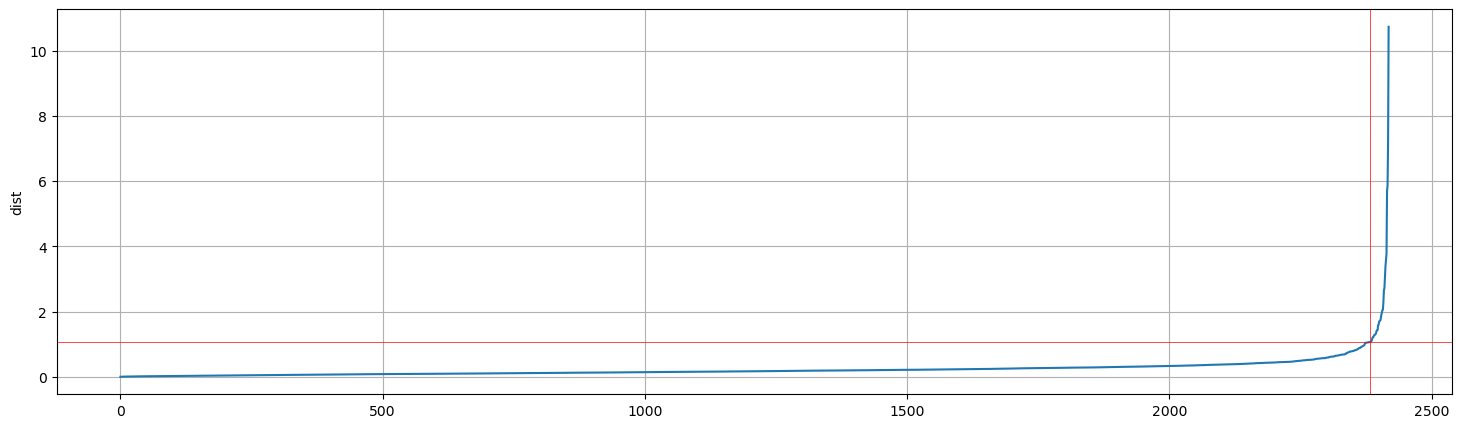

2024-12-02 14:09:12,507 - taxomizing_utils.py - root - get_ddist_kneepoint - INFO - knee_ddist: 0.9319, knee_index: 24/ 36


{'num_nodes': 2457, 'height': 9, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 2, 2, 4, 5, 8, 12]}


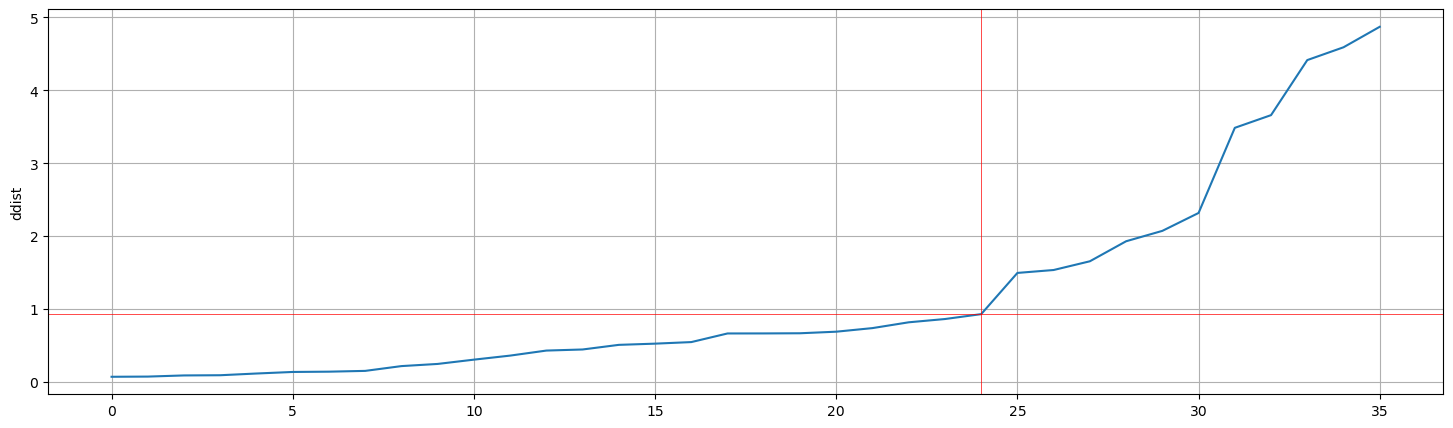

{'num_nodes': 2441, 'height': 6, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 3, 4, 10]}


In [6]:
plot=True
tree=linkage_to_btree(linkage_matrix, chunks_df)
print(get_tree_info_dict(tree))

# vertical flattening
threshold_dist, index = get_dist_kneepoint(tree,  include_leaves=False, plot=plot)
#threshold_dist, index = get_dist_std(tree, std_factor=1.0, include_leaves=False, plot=plot)

tree=do_dist_flattening(tree, threshold_dist=threshold_dist)
print(get_tree_info_dict(tree))

#horizontal flattening
add_ddist(tree)

threshold_ddist, index = get_ddist_kneepoint(tree, include_leaves=False, plot=plot)
#threshold_ddist, index = get_ddist_std(tree, std_factor=1.0, include_leaves=False, plot=plot)
tree=do_ddist_flattening(tree, threshold_ddist=threshold_ddist)
print(get_tree_info_dict(tree))

In [7]:
def recover_leaf_parents(tree):

    used_ids=[n.name for n in PreOrderIter(tree)]
    free_ids=set(range(max(used_ids)+1))-set(used_ids)

    new_ids=[]
    for node in PreOrderIter(tree):

        if node.is_leaf: continue
        children_is_leaf=[n.is_leaf for n in node.children]

        num_leaf_children=children_is_leaf.count(True)
        num_node_children=children_is_leaf.count(False)

        if num_node_children==0: continue
        if num_leaf_children==0: continue

        old_child_order=[n for n in node.children if not n.is_leaf]
        new_parent_node_id=free_ids.pop()
        new_parent_node=Node(new_parent_node_id)
        new_ids.append(new_parent_node_id)

        for child in node.children:
            if child.is_leaf:
                child.parent=new_parent_node
                
        new_parent_node.parent=node
        new_child_order=[new_parent_node]+old_child_order
        node.children=tuple(new_child_order)

    return tree

tree=recover_leaf_parents(tree)
print(get_tree_info_dict(tree))

{'num_nodes': 2445, 'height': 6, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 3, 4, 14]}


In [ ]:
taxomizer=LinkageTaxomizingPipeline()
taxomizer.get_config()

In [116]:
tree=taxomizer.get_flattened_tree(chunks_df=chunks_df, plot=False)
print(get_tree_info_dict(tree))

2024-12-02 11:12:58,747 - __init__.py - beesup_llm - get_flattened_tree - INFO - binary tree: {'num_nodes': 4839, 'height': 90, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
2024-12-02 11:12:58,760 - taxomizing_utils.py - root - get_dist_kneepoint - INFO - knee_dist: 0.3829, knee_index: 2344/ 2419
2024-12-02 11:12:59,461 - __init__.py - beesup_llm - get_flattened_tree - INFO - dist  tree: {'num_nodes': 2495, 'height': 19, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 1, 1, 1, 1, 1, 1, 1, 2]}
2024-12-02 11:12:59,470 - taxomizing_utils.py - root - get_ddist_kneepoint - INFO - knee_ddist: 0.0352, knee_index: 60/ 74
2024-12-02 11:12:59,583 - __init__.py - beesup_llm - get_flattened_tree - INFO - ddist tree: {'num_nodes': 2447, 'height': 4, 'num_root_children': 5, 'num_leaves': 2420, 'num_per_height': [1, 1, 5, 20]}


{'num_nodes': 2447, 'height': 4, 'num_root_children': 5, 'num_leaves': 2420, 'num_per_height': [1, 1, 5, 20]}


In [8]:
with open("tree.pkl", "wb") as f:
    pickle.dump(tree, f)

In [15]:
from anytree import RenderTree
for pre, fill, node in RenderTree(tree):
    if node.is_leaf:
        print(f"{pre}[{node.name}] {getattr(node,'dist',0):.2f} {node.label}")
        continue

    #print(f"{pre}({node.name}) {getattr(node,'dist',0):.2f} {node.size-1} descendants/ {len(node.children)} children")

    children_is_leaf=[n.is_leaf for n in node.children]
    num_leaf_children=children_is_leaf.count(True)
    num_node_children=children_is_leaf.count(False)
    
    print(f"{pre}({node.name}) {getattr(node,'dist',0):.2f} {num_leaf_children} leaf_children/ {num_node_children} node_children")

    


(4838) 10.73 0 leaf_children/ 2 node_children
├── (4836) 5.86 0 leaf_children/ 3 node_children
│   ├── (4817) 1.44 233 leaf_children/ 0 node_children
│   │   ├── [689] 1.44 Merkmale/ Die Körperlänge der Königin beträgt 16–18 mm  der Arbeiterin
│   │   ├── [750] 1.44 Merkmale/ Die Tiere erreichen eine Körperlänge von 17 bis 19 mm
│   │   ├── [765] 1.44 Merkmale/ Die Tiere erreichen eine Körperlänge von 15 bis 18 mm
│   │   ├── [816] 1.44 Merkmale/ Die Tiere erreichen eine Körperlänge von 15 bis 17 mm
│   │   ├── [632] 1.44 Merkmale/ Die Tiere erreichen eine Körperlänge von 22 bis 26 mm
│   │   ├── [727] 1.44 Merkmale/ Die Tiere erreichen eine Körperlänge von 19 bis 22 mm
│   │   ├── [779] 1.44 Merkmale/ Die Wiesenhummeln gehören zu den kleineren Hummelarten. Die Arbeiterinnen und
│   │   ├── [801] 1.44 Merkmale/ Die Weibchen der Feldhummeln werden 21 bis 24 Millimeter groß
│   │   ├── [681] 1.44 Körperbau/ Die Gartenhummel trägt an der Vorder- und Hinterkante des Brustkorbs
│   │   ├── 

In [32]:
import pickle

In [33]:
with open("tree.pkl", "wb") as f:
    pickle.dump(tree, f)

In [34]:
with open("tree.pkl", "rb") as f: 
    loaded_tree = pickle.load(f)

## Multiway Tree via HDBScan

In [8]:
taxomizer=HDBScanTaxomizingPipeline()
taxomizer.load_clusterer(
    min_cluster_size=2, #5
    min_samples=1, #None
    alpha=1.0, #1.0
    leaf_size=40, #40
    cluster_selection_epsilon=0.1, #0.0
    cluster_selection_method="eom", #eom, leaf
    allow_single_cluster=False, #False
    #metric='precomputed',
    #metric='euclidean',
    #gen_min_span_tree=True,
)

taxomizer.fit_chunks_df(chunks_df)

chunks_df['cid']=taxomizer.clusterer.labels_

nodes_df=taxomizer.nodes_df
member_df=taxomizer.member_df
member_tree=taxomizer.member_tree

print(f"root children: {len(member_tree.children)}")

# dendro_df=taxomizer.clusterer.single_linkage_tree_.to_pandas()
# dendro_df.rename(columns={'distance':'dist'},inplace=True)
# dendro_df['did']=dendro_df.index

2024-11-27 09:53:02,286 - __init__.py - beesup_llm - __init__ - INFO - 0001_TAXOMIZING initialised
2024-11-27 09:53:03,002 - __init__.py - beesup_llm - fit - INFO - number of clusters: 372
2024-11-27 09:53:03,004 - __init__.py - beesup_llm - fit - INFO - number of clustered: 1807
2024-11-27 09:53:03,005 - __init__.py - beesup_llm - fit - INFO - number of unclustered: 613
2024-11-27 09:53:04,635 - __init__.py - beesup_llm - fit_chunks_df - INFO - tree.height: 169
2024-11-27 09:53:05,730 - __init__.py - beesup_llm - fit_chunks_df - INFO - member_tree.size: 2894


root children: 2


In [77]:
from anytree import RenderTree
for pre, fill, node in RenderTree(member_tree):
    if node.is_leaf: continue
    print(f"{pre}{node.name} ... Node with {node.size-1} descdendants/ {len(node.children)} children")

3889 ... Node with 3501 descdendants/ 2 children
├── 3891 ... Node with 6 descdendants/ 6 children
└── 3890 ... Node with 3493 descdendants/ 2 children
    ├── 3893 ... Node with 222 descdendants/ 2 children
    │   ├── 3894 ... Node with 52 descdendants/ 4 children
    │   │   ├── 3898 ... Node with 12 descdendants/ 12 children
    │   │   └── 3899 ... Node with 36 descdendants/ 14 children
    │   │       ├── 3903 ... Node with 9 descdendants/ 9 children
    │   │       └── 3902 ... Node with 13 descdendants/ 2 children
    │   │           ├── 3904 ... Node with 5 descdendants/ 5 children
    │   │           └── 3905 ... Node with 6 descdendants/ 6 children
    │   └── 3895 ... Node with 168 descdendants/ 2 children
    │       ├── 3897 ... Node with 30 descdendants/ 13 children
    │       │   ├── 3901 ... Node with 5 descdendants/ 5 children
    │       │   └── 3900 ... Node with 12 descdendants/ 12 children
    │       └── 3896 ... Node with 136 descdendants/ 16 children
    │    

In [ ]:
plot_emb_clustering_scatter_3d(nodes_df[nodes_df.is_leaf])

In [10]:
linkage_df

,left_child,right_child,dist,size
0,1045.0,1052.0,0.009568,2.0
1,1157.0,1617.0,0.009808,2.0
2,1524.0,1529.0,0.010272,2.0
3,1752.0,1824.0,0.011195,2.0
4,2230.0,2266.0,0.012130,2.0
...,...,...,...,...
2414,4820.0,4831.0,3.780880,459.0
2415,4832.0,4834.0,5.712151,856.0
2416,4817.0,4835.0,5.855102,1089.0
2417,4829.0,4833.0,7.240815,1331.0


In [9]:
dendro_df=taxomizer.clusterer.single_linkage_tree_.to_pandas()
dendro_df.rename(columns={'distance':'dist'},inplace=True)
dendro_df

,parent,left_child,right_child,dist,size
0,2420,1045.0,1052.0,0.009568,2.0
1,2421,1157.0,1617.0,0.009808,2.0
2,2422,1529.0,1524.0,0.010272,2.0
3,2423,1824.0,1752.0,0.011195,2.0
4,2424,2230.0,2266.0,0.012130,2.0
...,...,...,...,...,...
2414,4834,4833.0,1209.0,0.367480,2416.0
2415,4835,4834.0,2194.0,0.370234,2417.0
2416,4836,4835.0,663.0,0.381080,2418.0
2417,4837,4836.0,318.0,0.391034,2419.0


In [ ]:
dendro_df=taxomizer.clusterer.single_linkage_tree_.to_pandas()
dendro_df.rename(columns={'distance':'dist'},inplace=True)

def dendro_df_to_anytree(dendro_df, chunks_df):
    dendro_df.sort_values(by='parent', ascending=False, inplace=True)

    nodes={}
    for _,row in dendro_df.iterrows():
        for child in ['left_child','right_child']:
            node_id=int(row[child])
            if node_id in nodes: continue

            nodes[node_id]=Node(node_id)
            nodes[node_id].__setattr__('dist',row.dist)

            if node_id not in chunks_df.index: continue

            for k,v in chunks_df.loc[node_id].items():
                if k in ['is_leaf','is_root','size','depth','height']: continue
                nodes[node_id].__setattr__(k,v)
            
    for _,row in dendro_df.iterrows():
            parent_id=int(row.parent)
            if parent_id not in nodes:
                 nodes[parent_id]=Node(parent_id)

            for child in ['left_child','right_child']:
                 node_id=int(row[child])
                 nodes[node_id].parent=nodes[parent_id]
               
    for node in nodes.values():
        if node.parent is None:  # Identify root nodes of disconnected components
            break
    
    return node



dendro_tree=dendro_df_to_anytree(dendro_df,chunks_df)
print(get_tree_info_dict(dendro_tree))
dendro_tree

{'num_nodes': 7777, 'num_leaves': 3889, 'mean_num_children': 2.0}


Node('/7776')

7777
i=3777 3777/3777	                         
4000


In [113]:
from anytree import RenderTree
for pre, fill, node in RenderTree(tax_tree):
    if node.is_leaf:
        print(f"{pre}{node.name} {node.label}")
        continue
    
    print(f"{pre}{node.name} ... Node with {node.size-1} descdendants/ {len(node.children)} children")

3889 ... Node with 2930 descdendants/ 2 children
├── 3891 ... Node with 204 descdendants/ 2 children
│   ├── 3892 ... Node with 48 descdendants/ 4 children
│   │   ├── 2272 Cluster with 1 members
│   │   ├── 2474 Cluster with 1 members
│   │   ├── 3896 ... Node with 12 descdendants/ 12 children
│   │   │   ├── 2214 Cluster with 1 members
│   │   │   ├── 2247 Cluster with 1 members
│   │   │   ├── 2265 Cluster with 1 members
│   │   │   ├── 2282 Cluster with 1 members
│   │   │   ├── 2347 Cluster with 1 members
│   │   │   ├── 2373 Cluster with 1 members
│   │   │   ├── 2380 Cluster with 1 members
│   │   │   ├── 2394 Cluster with 1 members
│   │   │   ├── 2467 Cluster with 1 members
│   │   │   ├── 2523 Cluster with 1 members
│   │   │   ├── 2530 Cluster with 1 members
│   │   │   └── 2537 Cluster with 1 members
│   │   └── 3897 ... Node with 32 descdendants/ 32 children
│   │       ├── 1894 Cluster with 1 members
│   │       ├── 1900 Cluster with 1 members
│   │       ├── 1906 Cluster

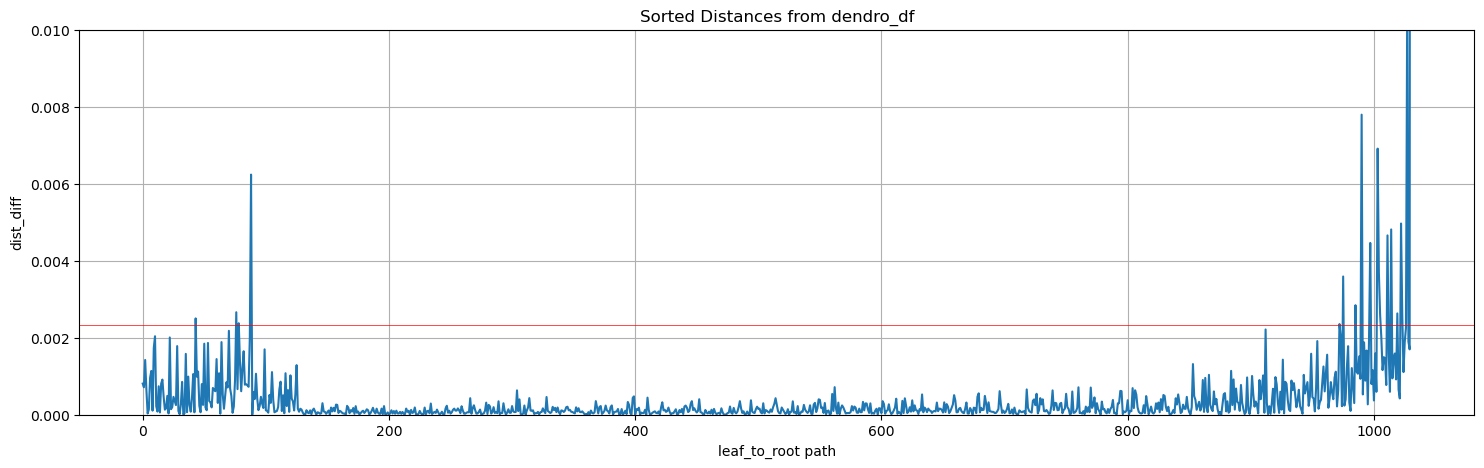

In [ ]:
import matplotlib.pyplot as plt

# Extract the 'dist' column and sort it
sorted_dist = path_df['dist_diff'].dropna()#.sort_values()

# Plot the sorted distances
plt.figure(figsize=(18, 5))
plt.plot(sorted_dist.values)
plt.axhline(y=path_df['dist_diff'].std(), color='red', linestyle='-', linewidth=0.5)
plt.xlabel('leaf_to_root path')
plt.ylabel('dist_diff')
plt.title('Sorted Distances from dendro_df')
plt.ylim(0, 0.01)  # Adjust the y-axis range
plt.grid(True)
plt.show()


In [154]:
data=[]
for cid, size in member_df.cid.value_counts().to_dict().items():

    predicates_str=''
    predicates=[]
    portions=[]
    
    for predicate, p in member_df[member_df.cid==cid]['predicate'].value_counts(normalize=True).to_dict().items():
        predicates_str+=f'{p:.2f}: {predicate}; '
        predicates.append(predicate)
        portions.append(p)

    row=dict(
        cid=cid,
        size=size,
        predicates_str=predicates_str,
        predicates=predicates,
        portions=portions,
    )

    data.append(row)

pd.DataFrame(data)

,cid,size,predicates_str,predicates,portions
0,5.0,127,0.72: Kuckucksbienen; 0.28: Wirtsbienen;,"[Kuckucksbienen, Wirtsbienen]","[0.7165354330708661, 0.28346456692913385]"
1,4.0,126,0.40: Sozialverhalten; 0.32: Familie; 0.28: Vo...,"[Sozialverhalten, Familie, Vorkommen und Leben...","[0.40476190476190477, 0.31746031746031744, 0.2..."
2,0.0,120,0.82: Familie; 0.17: Wissenschaftlicher Name; ...,"[Familie, Wissenschaftlicher Name, Umgangsspra...","[0.825, 0.16666666666666666, 0.008333333333333..."
3,10.0,103,1.00: Nistweise;,[Nistweise],[1.0]
4,3.0,102,0.92: Umgangssprachliche Bezeichnungen; 0.05: ...,"[Umgangssprachliche Bezeichnungen, Merkmale, S...","[0.9215686274509803, 0.049019607843137254, 0.0..."
5,7.0,96,1.00: Pollensammelverhalten;,[Pollensammelverhalten],[1.0]
6,1.0,81,1.00: Umgangssprachliche Bezeichnungen;,[Umgangssprachliche Bezeichnungen],[1.0]
7,2.0,66,0.91: Merkmale; 0.09: Kurzbeschreibung;,"[Merkmale, Kurzbeschreibung]","[0.9090909090909091, 0.09090909090909091]"
8,11.0,62,1.00: Nistweise;,[Nistweise],[1.0]
9,8.0,62,1.00: Pollensammelverhalten;,[Pollensammelverhalten],[1.0]


In [101]:
from anytree import RenderTree
for pre, fill, node in RenderTree(taxomizer.member_tree):
    if node.is_leaf: continue
    print(f"{pre}{node.name} ... Node with {node.size-1} descdendants/ {len(node.children)} children")

3889 ... Node with 3074 descdendants/ 2 children
├── 3891 ... Node with 204 descdendants/ 2 children
│   ├── 3892 ... Node with 48 descdendants/ 4 children
│   │   ├── 3896 ... Node with 12 descdendants/ 12 children
│   │   └── 3897 ... Node with 32 descdendants/ 32 children
│   └── 3893 ... Node with 154 descdendants/ 2 children
│       ├── 3895 ... Node with 28 descdendants/ 28 children
│       └── 3894 ... Node with 124 descdendants/ 58 children
│           ├── 3901 ... Node with 14 descdendants/ 14 children
│           └── 3900 ... Node with 52 descdendants/ 52 children
└── 3890 ... Node with 2868 descdendants/ 2 children
    ├── 3899 ... Node with 21 descdendants/ 21 children
    └── 3898 ... Node with 2845 descdendants/ 2 children
        ├── 3903 ... Node with 349 descdendants/ 2 children
        │   ├── 3905 ... Node with 14 descdendants/ 14 children
        │   └── 3904 ... Node with 333 descdendants/ 2 children
        │       ├── 3907 ... Node with 12 descdendants/ 12 childr

In [108]:
from anytree import Node, RenderTree, PreOrderIter, findall
from anytree.exporter import DotExporter

def reduce_tree_depth(tree, max_depth):
    """
    Reduce the depth of an anytree tree by moving all descendant leaf nodes
    to the node at the specified max_depth and removing deeper branches.

    Args:
        tree (Node): The root of the tree.
        max_depth (int): The depth to cut off branches.

    Returns:
        Node: The modified tree root.
    """
    # Traverse the tree and find all nodes at the max depth
    nodes_at_max_depth = [node for node in PreOrderIter(tree) if (node.depth == max_depth) and (not node.is_leaf)]

    for node in nodes_at_max_depth:
        # Collect all descendant leaves of this node
        descendant_leaves = [leaf for leaf in PreOrderIter(node) if leaf.is_leaf]

        # Reassign all descendant leaves as direct children of this node
        for leaf in descendant_leaves:
            if leaf.parent != node:  # Ensure no self-parenting or redundant reassignment
                leaf.parent = node

        # Remove all previous children (now redundant) from this node
        for child in list(node.children):
            if child not in descendant_leaves:
                child.parent = None

    return tree

tax_tree=copy.deepcopy(taxomizer.member_tree)
tax_tree=reduce_tree_depth(copy.deepcopy(tax_tree), 4)

for node in PreOrderIter(tax_tree):
    if node.is_leaf: continue
    node.__delattr__('emb')

tax_tree=propagate_emb(tax_tree)
tax_tree

Node('/3889', cid=nan, decendant_cids={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}, dist=nan, emb=array([-0.00024735,  0.01230525,  0.03133485, ..., -0.01900094,
        0.00526422,  0.0116678 ], dtype=float32), id=3889, label='Cluster with 3075 members', lambda_val=nan, object=nan, parent_id=nan, predicate=nan, subject=nan)

In [109]:
from anytree import RenderTree
for pre, fill, node in RenderTree(tax_tree):
    if node.is_leaf: continue
    print(f"{pre}{node.name} ... Node with {node.size-1} descdendants/ {len(node.children)} children")

3889 ... Node with 2930 descdendants/ 2 children
├── 3891 ... Node with 204 descdendants/ 2 children
│   ├── 3892 ... Node with 48 descdendants/ 4 children
│   │   ├── 3896 ... Node with 12 descdendants/ 12 children
│   │   └── 3897 ... Node with 32 descdendants/ 32 children
│   └── 3893 ... Node with 154 descdendants/ 2 children
│       ├── 3895 ... Node with 28 descdendants/ 28 children
│       └── 3894 ... Node with 124 descdendants/ 58 children
│           ├── 3901 ... Node with 14 descdendants/ 14 children
│           └── 3900 ... Node with 52 descdendants/ 52 children
└── 3890 ... Node with 2724 descdendants/ 2 children
    ├── 3899 ... Node with 21 descdendants/ 21 children
    └── 3898 ... Node with 2701 descdendants/ 2 children
        ├── 3903 ... Node with 329 descdendants/ 2 children
        │   ├── 3905 ... Node with 14 descdendants/ 14 children
        │   └── 3904 ... Node with 313 descdendants/ 313 children
        └── 3902 ... Node with 2370 descdendants/ 2 children
  

# Generate Headers

- key der am nächsten am mean embedding ist?

In [9]:
#Load Model
modelwrap=LlamaModelWrap()
modelwrap.get_config()

modelwrap.prepare_inference()

2024-12-02 14:10:55,842 - __init__.py - beesup_llm - __init__ - INFO - 0001_GEN_MODEL initialised
2024-12-02 14:10:55,844 - __init__.py - beesup_llm - load_model - INFO - Loading model meta-llama/Meta-Llama-3.1-8B-Instruct
2024-12-02 14:10:56,811 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def get_diverse_order(embs, start_idx):
    """
    Optimized version to select vectors iteratively such that each next vector
    has the lowest average similarity to all previously selected vectors.

    Args:
        embeddings (np.ndarray): Array of embedding vectors (shape: [n_samples, n_features]).
        start_idx (int): Index of the starting vector.

    Returns:
        list: Indices of vectors in the order they are selected.
    """
    # Step 1: Compute pairwise cosine similarity matrix once
    similarity_matrix = cosine_similarity(embs)
    n_vectors = len(embs)
    
    # Step 2: Initialize tracking variables
    selected_indices = [start_idx]  # Start with the given vector
    unselected_indices = set(range(n_vectors)) - {start_idx}
    cumulative_similarity = np.zeros(n_vectors)  # Keep track of cumulative similarity for all vectors
    
    # Step 3: Update cumulative similarity for all unselected vectors
    cumulative_similarity += similarity_matrix[start_idx]

    # Step 4: Iteratively select the most dissimilar vector
    while unselected_indices:
        # Compute average similarity only for unselected vectors
        avg_similarity = {idx: cumulative_similarity[idx] / len(selected_indices) for idx in unselected_indices}
        
        # Select the vector with the lowest average similarity
        next_idx = min(avg_similarity, key=avg_similarity.get)
        
        # Update tracking variables
        selected_indices.append(next_idx)
        unselected_indices.remove(next_idx)
        
        # Update cumulative similarity with the newly selected vector
        cumulative_similarity += similarity_matrix[next_idx]
    
    return selected_indices

def get_headers_df(tree, chunks_df):

    propagate_emb_from_leaves(tree)

    chunk_embs=np.vstack(chunks_df['emb'].values)
    header_embs=np.vstack([n.emb for n in PreOrderIter(tree) if not n.is_leaf])
    match_matrix=cosine_similarity(header_embs,chunk_embs)

    headers_data=[]
    for pre, fill, node in RenderTree(tree): #RenderTree traverses in pre-order
        if node.is_leaf: continue

        chunk_mask = np.zeros(len(chunks_df), dtype=bool)
        chunk_mask[[n.name for n in node.leaves]] = True

        ranking_df=chunks_df[chunk_mask].copy()
        #ranking_df=chunks_df[chunk_mask].reset_index(drop=True).copy()

        ranking_df['score']=match_matrix[len(headers_data)][chunk_mask]
        ranking_df.sort_values(by='score', ascending=False, inplace=True)
        #ranking_df.reset_index(drop=True, inplace=True)

        diverse_order = get_diverse_order(np.vstack(ranking_df['emb'].values), 0)
        ranking_df=ranking_df.iloc[diverse_order]#.reset_index(drop=True)

        ranking_df[1:]=ranking_df[1:][::-1] # growing 'concentric circles' starting from mean point
        node.__setattr__("chunk_idx_order",list(ranking_df.index.values))

        header_row=dict(
            id=node.name,
            parent_id=node.parent.name if node.parent else None,

            emb=node.emb,
            size=node.size,
            depth=node.depth,
            height=node.height,
            num_children=len(node.children),

            ranking_df=ranking_df,

            pre=pre,
        )
        headers_data.append(header_row)

    headers_df=pd.DataFrame(headers_data)

    headers_df['header']=None
    headers_df.loc[0,'header']='Knowledge About Wild Bees'

    return headers_df

headers_df=get_headers_df(tree, chunks_df)
headers_df

,id,parent_id,emb,size,depth,height,num_children,ranking_df,pre,header
0,4838,NaN,"[0.0073994547, -0.004193658, 0.013967146, -0.0...",2445,0,6,2,...,,Knowledge About Wild Bees
1,4836,4838.0,"[0.006481899, -0.005351508, 0.012210034, -0.00...",1104,1,5,3,...,├──,None
2,4817,4836.0,"[0.01247572, -0.0047603943, -0.0022699537, -0....",234,2,1,233,...,│ ├──,None
3,4832,4836.0,"[-0.00010378944, -0.003766065, 0.019764308, 0....",405,2,4,2,...,│ ├──,None
4,2420,4832.0,"[-0.0019910072, -0.0027447569, 0.025138104, 0....",89,3,1,88,...,│ │ ├──,None
5,4830,4832.0,"[0.0017834284, -0.004787373, 0.0143905105, -0....",315,3,3,3,...,│ │ └──,None
6,4827,4830.0,"[0.005667258, -0.006057881, 0.010087628, -0.00...",129,4,2,2,...,│ │ ├──,None
7,2421,4827.0,"[0.006450436, -0.00979401, 0.0052721407, -0.00...",82,5,1,81,...,│ │ │ ├──,None
8,4813,4827.0,"[0.0048840796, -0.0023217516, 0.014903116, -0....",46,5,1,45,...,│ │ │ └──,None
9,4819,4830.0,"[0.004261309, -0.0053697107, 0.015986184, -0.0...",50,4,1,49,...,│ │ ├──,None


In [135]:
ranking_df=headers_df.iloc[2].ranking_df
ranking_df

,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb,score
1209,"Hylaeus communis (Nylander, 1852)\nGefährdung\...","Hylaeus communis (Nylander, 1852)",Gefährdung,Die Art ist häufig und ungefährdet.,wikipedia,Text,1,6,Gefährdung/ Die Art ist häufig und ungefährdet.,"[0.018126495, -0.015147373, 0.018778542, 0.011...",0.921901
736,"Anthidiellum strigatum (Panzer, 1804)\nGefährd...","Anthidiellum strigatum (Panzer, 1804)",Gefährdung,Die IUCN listet die Art als nicht gefährdet (l...,wikipedia,Text,1,26,Gefährdung/ Die IUCN listet die Art als nicht ...,"[0.01851051, 0.005509234, 0.008908377, -0.0105...",0.807065
1345,"Melitta tricincta (Kirby, 1802)\nGefährdung\nD...","Melitta tricincta (Kirby, 1802)",Gefährdung,Die Art ist auf der Roten Liste gefährdeter Ti...,wikipedia,Text,1,17,Gefährdung/ Die Art ist auf der Roten Liste ge...,"[0.016798738, -0.004657673, 0.019931749, -0.00...",0.782473
495,"Bombus mucidus (Gerstäcker, 1869)\nGefährdung\...","Bombus mucidus (Gerstäcker, 1869)",Gefährdung,Die Grauweiße Hummel wird in Deutschland in de...,wikipedia,Text,1,17,Gefährdung/ Die Grauweiße Hummel wird in Deuts...,"[0.0057674763, -0.0055622384, 0.017941978, -0....",0.782259
730,"Megachile centuncularis (Linnaeus, 1758)\nGefä...","Megachile centuncularis (Linnaeus, 1758)",Gefährdung,Die IUCN listet die Art als nicht gefährdet (l...,wikipedia,Text,1,40,Gefährdung/ Die IUCN listet die Art als nicht ...,"[0.009960621, 0.0091758175, 0.01776121, -0.014...",0.823046
2376,"Bombus veteranus (Fabricius, 1793)\nGefährdung...","Bombus veteranus (Fabricius, 1793)",Gefährdung,Die Sandhummel gilt in Deutschland als gefährd...,wikipedia,Text,1,17,Gefährdung/ Die Sandhummel gilt in Deutschland...,"[0.008148397, 0.0007043335, 0.024658078, 0.000...",0.717149
509,"Bombus ruderarius (Müller, 1776)\nGefährdung\n...","Bombus ruderarius (Müller, 1776)",Gefährdung,Die Grashummel leidet unter der landwirtschaft...,wikipedia,Text,1,32,Gefährdung/ Die Grashummel leidet unter der la...,"[0.010522594, -0.004667593, 0.01805225, 0.0159...",0.691483
791,"Anthidium punctatum (Latreille, 1809)\nGefährd...","Anthidium punctatum (Latreille, 1809)",Gefährdung,Die Weißfleckige Wollbiene ist auf der Vorwarn...,wikipedia,Text,1,9,Gefährdung/ Die Weißfleckige Wollbiene ist auf...,"[0.0030892415, -0.015939875, 0.013772493, 0.00...",0.696129
853,"Systropha curvicornis (Scopoli, 1770)\nGefährd...","Systropha curvicornis (Scopoli, 1770)",Gefährdung,Die Art wurde in der letzten Zeit besonders in...,wikipedia,Text,1,50,Gefährdung/ Die Art wurde in der letzten Zeit ...,"[0.01697052, -0.022908527, 0.016758818, 0.0087...",0.705616
1558,"Bombus mendax (Gerstäcker, 1869)\nGefährdung\n...","Bombus mendax (Gerstäcker, 1869)",Gefährdung,Die Trughummel gilt in Deutschland aufgrund ei...,wikipedia,Text,1,16,Gefährdung/ Die Trughummel gilt in Deutschland...,"[0.004699636, 0.0009513444, 0.010068654, -0.00...",0.652071


{'num_nodes': 2445, 'height': 6, 'num_root_children': 2, 'num_leaves': 2420, 'num_per_height': [1, 1, 2, 3, 4, 14]}


In [28]:
# Function to delete all leaves
def delete_leaves(node):
    # Filter out leaf nodes from the children of the current node
    node.children = tuple(child for child in node.children if child.children)
    # Recursively process non-leaf children
    for child in node.children:
        delete_leaves(child)

htree=copy.deepcopy(tree)
delete_leaves(htree)
print(get_tree_info_dict(htree))

{'num_nodes': 25, 'height': 5, 'num_root_children': 2, 'num_leaves': 14, 'num_per_height': [1, 1, 2, 3, 4]}


In [31]:
for pre, fill, node in RenderTree(htree):
    node.__setattr__('toc_prefix',pre)

In [36]:
htree.children[0]

Node('/4838/4836', chunk_idx_order=[585, 2193, 730, 466, 1208, 2206, 1136, 755, 2271, 1209, 513, 149, 277, 698, 495, 1096, 597, 486, 1345, 152, 804, 2278, 736, 112, 831, 1029, 2215, 2175, 1577, 991, 133, 2303, 873, 805, 193, 2119, 2234, 734, 1679, 608, 2178, 1712, 1346, 634, 2210, 853, 2316, 596, 1667, 2319, 2344, 349, 675, 1557, 508, 217, 1841, 464, 219, 488, 1903, 2314, 2305, 1674, 1361, 1608, 2181, 489, 1803, 791, 73, 825, 878, 135, 1213, 1059, 484, 509, 366, 20, 465, 774, 94, 2275, 1650, 2083, 503, 2389, 516, 810, 2004, 487, 740, 1167, 578, 798, 663, 299, 2194, 2229, 79, 757, 1851, 1844, 2179, 446, 742, 2217, 2116, 1682, 1419, 2174, 1528, 338, 613, 2244, 2140, 781, 2117, 1017, 300, 1214, 2093, 930, 2382, 746, 318, 234, 836, 2028, 460, 1152, 1538, 1153, 695, 2272, 1044, 2253, 2255, 2183, 263, 2349, 2245, 1951, 54, 666, 1545, 553, 451, 1575, 462, 748, 265, 2186, 830, 2188, 1736, 1610, 2304, 1692, 536, 765, 342, 2152, 1886, 594, 499, 1038, 1558, 2045, 2144, 602, 1254, 494, 1823, 2219,

In [29]:
for pre, fill, node in RenderTree(htree):
    print(f"{pre}({node.name}) {getattr(node,'dist',0):.2f} {num_leaf_children} leaf_children/ {num_node_children} node_children")

(4838) 10.73 43 leaf_children/ 0 node_children
├── (4836) 5.86 43 leaf_children/ 0 node_children
│   ├── (4817) 1.44 43 leaf_children/ 0 node_children
│   ├── (4832) 3.39 43 leaf_children/ 0 node_children
│   │   ├── (2420) 0.00 43 leaf_children/ 0 node_children
│   │   └── (4830) 2.72 43 leaf_children/ 0 node_children
│   │       ├── (4827) 2.06 43 leaf_children/ 0 node_children
│   │       │   ├── (2421) 0.00 43 leaf_children/ 0 node_children
│   │       │   └── (4813) 1.32 43 leaf_children/ 0 node_children
│   │       ├── (4819) 1.61 43 leaf_children/ 0 node_children
│   │       └── (4822) 1.73 43 leaf_children/ 0 node_children
│   └── (4834) 3.78 43 leaf_children/ 0 node_children
│       ├── (4820) 1.71 43 leaf_children/ 0 node_children
│       └── (4831) 3.09 43 leaf_children/ 0 node_children
│           ├── (4816) 1.43 43 leaf_children/ 0 node_children
│           └── (4818) 1.59 43 leaf_children/ 0 node_children
└── (4837) 7.24 43 leaf_children/ 0 node_children
    ├── (4829) 2.

In [57]:
def build_prompt(selected_chunks_df):
    prompt=""
    prompt+="""
GIVEN:
- content subordinated to a subsection inside a table of contents
- table of contents unfolded until a certain subsection

TASK:
- make up the unknown subsection header under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundant headers
- don't explain your solution, just answer with a meaningful subsection header
""".strip()
    
    prompt+="\n\nTABLE OF CONTENTS:\n\n{tax}".format(**header_row)

    prompt+="\nCONTENT:\n"

    

    chunk_template="\n# {predicate}\n{object}\n\n"
    #chunk_template="\n# {subject}\n## {predicate}\n{object}\n\n"
    #template="\n{object}\n"

    max_prompt_chars=20000
    for i, chunk_row in header_row['ranking_df'].iterrows():

        if chunk_row.attr_type=='Text':
            chunk_template="{predicate}: {object}"
        
        elif chunk_row.attr_type=='Attribute':
            chunk_template="{predicate}: {object}"
        
        #prompt+=f"# CHUNK {i+1}:\n"+chunk_template.format(**chunk_row)+"\n\n"
        prompt+=f"\n{chunk_template.format(**chunk_row)}\n"

        if len(prompt)>max_prompt_chars:
            #prompt+="\n\n... and more chunks ...\n"
            break

    prompt+="\n\nSUBSECTION HEADER:\n"
    
    return prompt


def get_prompt(toc,selected_chunks_df):

    prompt=""
    prompt+="""
GIVEN:
- content subordinated to a subsection inside a table of contents
- table of contents unfolded until a certain subsection

TASK:
- make up the unknown summary of content for the concerning subsection under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundancies
- don't explain your solution, just answer with a meaningful summary of content
""".strip()
    
    

    prompt+="\n\nCONTENT:\n"

    max_prompt_chars=20000
    for i, chunk_row in selected_chunks_df.iterrows():

        if chunk_row.attr_type=='Text':
            chunk_template="{predicate}: {object}"
        
        elif chunk_row.attr_type=='Attribute':
            chunk_template="{predicate}: {object}"
        
        prompt+=f"\n{chunk_template.format(**chunk_row)}\n"

        if len(prompt)>max_prompt_chars:
            #prompt+="\n\n... and more chunks ...\n"
            break
    
    prompt+="\n\nTABLE OF CONTENTS:\n"
    prompt+="\n".join(toc)

    prompt+="\n\nSHORT SUMMARY OF CONTENT (ONE SENTENCE):\n"
    
    return prompt

toc=['Gesamtes Wissen über Wildbienen']
prompt=get_prompt(toc,chunks_df.loc[htree.chunk_idx_order].copy())
print(prompt)

GIVEN:
- content subordinated to a subsection inside a table of contents
- table of contents unfolded until a certain subsection

TASK:
- make up the unknown summary of content for the concerning subsection under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundancies
- don't explain your solution, just answer with a meaningful summary of content

CONTENT:

Umgangssprachliche Bezeichnungen: Dichtpunktierte Goldfurchenbiene

Flugzeit: Die überwinterte Wald-Kuckuckshummel fliegt von April bis Ende Juli, das Jung-Weibchen ab Juli und das Jung-Männchen ab Mitte Juli. Die Art ist univoltin und tritt folglich nur mit einer Generation im Jahr auf.

Requisiten: Sand

Synonyme: Osmia papaveris
Apis papaveris Latreille, 1799

Verbreitung und Lebensraum: A. lapponica ist in der ganzen Paläarktis verbreitet, von den Pyrenäen über die Ukraine und Zentralasien bis nach Japan. In Europ

In [59]:
completion=modelwrap(prompt, as_chat=True, stream=False, stop_strings=['\n'])
completion

'Wildbienen: Merkmale, Parasiten, Gefährdung, Phänologie, Lebensraum, Nomenklatur, Bienen im Recht, Schutz, Verbreitung, Merkmale, Parasiten, Gefährdung, Phänologie, Lebensraum, Nomenklatur, Bienen im Recht, Schutz, Verbreitung, Merkmale, Parasiten, Gefährdung, Phänologie, Lebensraum, Nomenklatur, Bienen im Recht, Schutz, Verbreitung, Merkmale, Parasiten, Gefährdung, Phänologie, Lebensraum, Nomenklatur, Bienen im Recht, Schutz, Verbreitung.'

In [58]:
toc=['Gesamtes Wissen über Wildbienen']
for pre, fill, node in RenderTree(htree):
    if node.is_root: continue

    toc.append(f"{node.toc_prefix} unknown summary of content")
    selected_chunks_df=chunks_df.loc[node.chunk_idx_order].copy()

    prompt=get_prompt(toc,selected_chunks_df)
    break
    
print(prompt)
    
    
    




GIVEN:
- content subordinated to a subsection inside a table of contents
- table of contents unfolded until a certain subsection

TASK:
- make up the unknown summary of content for the concerning subsection under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundancies
- don't explain your solution, just answer with a meaningful summary of content

CONTENT:

Merkmale: Die Biene hat eine Körperlänge von 10 bis 12 Millimeter, ist weit verbreitet und mäßig häufig. Die Weibchen sind überwiegend gelbbraun behaart, im Gesicht, auf dem Thorax und den Tergiten ist die Behaarung mit schwarzen Haaren vermischt. Der Kopf und die Ventralseite des Thorax ist weiß behaart. Die Tergite zwei bis vier haben am Hinterrand lockere Haarbinden, auf der Scheibe sind sie kurz, hell und lang, dunkel behaart. Die Schienenbürste (Scopa) ist weiß behaart. Die Wangen sind kurz. Das dritte Fühlerglie

In [39]:
selected_chunks_df=chunks_df.loc[htree.chunk_idx_order].copy()
selected_chunks_df

,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb
1110,"Halictus subauratus (Rossi, 1792)\nUmgangsspra...","Halictus subauratus (Rossi, 1792)",Umgangssprachliche Bezeichnungen,Dichtpunktierte Goldfurchenbiene,wildbienen-kataster,Attribute,1,2,Umgangssprachliche Bezeichnungen/ Dichtpunktie...,"[0.009831647, 0.005128517, 0.019163042, -0.010..."
831,"Bombus sylvestris (Lepeletier, 1832)\nFlugzeit...","Bombus sylvestris (Lepeletier, 1832)",Flugzeit,Die überwinterte Wald-Kuckuckshummel fliegt vo...,wikipedia,Text,1,33,Flugzeit/ Die überwinterte Wald-Kuckuckshummel...,"[-0.0010009763, 0.0071858317, 0.020514362, -0...."
60,"Andrena argentata (Smith, 1844)\nRequisiten\nSand","Andrena argentata (Smith, 1844)",Requisiten,Sand,wildbienen-kataster,Attribute,1,1,Requisiten/ Sand,"[0.0061063776, 0.010544457, 0.03496587, -0.004..."
1176,"Hoplitis papaveris (Latreille, 1799)\nSynonyme...","Hoplitis papaveris (Latreille, 1799)",Synonyme,"Osmia papaveris\nApis papaveris Latreille, 1799",wikipedia,Text,1,6,Synonyme/ Osmia papaveris Apis papaveris Latre...,"[0.015832115, -0.021689292, -0.002917206, 0.00..."
277,"Andrena lapponica (Zetterstedt, 1838)\nVerbrei...","Andrena lapponica (Zetterstedt, 1838)",Verbreitung und Lebensraum,A. lapponica ist in der ganzen Paläarktis verb...,wikipedia,Text,1,90,Verbreitung und Lebensraum/ A. lapponica ist i...,"[0.02794763, 0.006798221, 0.035339776, -0.0089..."
...,...,...,...,...,...,...,...,...,...,...
85,"Andrena bimaculata (Kirby, 1802)\nUmgangssprac...","Andrena bimaculata (Kirby, 1802)",Umgangssprachliche Bezeichnungen,Schwarzbeinige Rippensandbiene,wildbienen-kataster,Attribute,1,2,Umgangssprachliche Bezeichnungen/ Schwarzbeini...,"[0.008520949, 0.009088372, 0.02158144, -0.0107..."
2030,"Nomada succincta (Panzer, 1798)\nUmgangssprach...","Nomada succincta (Panzer, 1798)",Umgangssprachliche Bezeichnungen,Gegürtete Wespenbiene,wildbienen-kataster,Attribute,1,2,Umgangssprachliche Bezeichnungen/ Gegürtete We...,"[0.007604836, 0.015106233, 0.014912323, -0.009..."
1371,"Lasioglossum fulvicorne (Kirby, 1802)\nUmgangs...","Lasioglossum fulvicorne (Kirby, 1802)",Umgangssprachliche Bezeichnungen,Braunfühler-Schmalbiene,wildbienen-kataster,Attribute,1,1,Umgangssprachliche Bezeichnungen/ Braunfühler-...,"[0.017863248, 0.008596441, 0.011810378, -0.008..."
171,"Andrena flavipes (Panzer, 1799)\nUmgangssprach...","Andrena flavipes (Panzer, 1799)",Umgangssprachliche Bezeichnungen,Gewöhnliche Bindensandbiene,wildbienen-kataster,Attribute,1,2,Umgangssprachliche Bezeichnungen/ Gewöhnliche ...,"[0.012162507, 0.010407087, 0.012740758, -0.009..."


In [134]:
def add_taxonomy(headers_df):
    if 'tax' not in headers_df.columns: headers_df['tax']=None
    tax=""
    break_next=False
    for i,row in headers_df.iterrows():
        if break_next: break
    
        if row.header is None:
            tax+=f"{row.pre} unknown summarization\n"
            break_next=True
        else:
            tax+=f"{row.pre}{row.sumup}\n"
        
        headers_df.at[i,'tax']=tax
    
    return headers_df

def build_sumup_prompt(header_row):
    prompt=""
    prompt+="""
GIVEN:
- a set of chunks all subordinated to the same field of knowledge

TASK:
- briefly summarize the field of knowledge the given chunks are about inside a given taxonomy of hierarchical arranged knowledge fields, be as concise as possible.
- don't explain your solution, just answer with two or three sentences
""".strip()

    #prompt+="\n\nKNOWLEDGE TAXONOMY:\n\n{tax}".format(**header_row)

    prompt+="\n\nCHUNKS:\n"

    max_prompt_chars=5000
    for i, chunk_row in header_row['ranking_df'].iterrows():

        if chunk_row.attr_type=='Text':
            chunk_template="{object}"
        
        elif chunk_row.attr_type=='Attribute':
            chunk_template="{predicate}: {object}"
        
        prompt+=f"# CHUNK {i+1}:\n"+chunk_template.format(**chunk_row)+"\n\n"
        if len(prompt)>max_prompt_chars:
            prompt+="\n\n... and more chunks ...\n"
            break

    prompt+="\n\nSUMMARIZATION:\n"
    
    return prompt

headers_df[['tax','sumup']]=None,None
headers_df.loc[0,'sumup']='Knowledge About Wild Bees'
add_taxonomy(headers_df)
prompt=build_sumup_prompt(headers_df.iloc[1])
print(prompt)

GIVEN:
- a set of chunks all subordinated to the same field of knowledge

TASK:
- briefly summarize the field of knowledge the given chunks are about inside a given taxonomy of hierarchical arranged knowledge fields, be as concise as possible.
- don't explain your solution, just answer with two or three sentences

CHUNKS:
# CHUNK 1:
Die Biene hat eine Körperlänge von 10 bis 12 Millimeter, ist weit verbreitet und mäßig häufig. Die Weibchen sind überwiegend gelbbraun behaart, im Gesicht, auf dem Thorax und den Tergiten ist die Behaarung mit schwarzen Haaren vermischt. Der Kopf und die Ventralseite des Thorax ist weiß behaart. Die Tergite zwei bis vier haben am Hinterrand lockere Haarbinden, auf der Scheibe sind sie kurz, hell und lang, dunkel behaart. Die Schienenbürste (Scopa) ist weiß behaart. Die Wangen sind kurz. Das dritte Fühlerglied ist so lang wie die darauf folgenden drei Glieder zusammen. Die Männchen ähneln dem Weibchen, haben jedoch ein hellgelb gezeichnetes Gesicht und auf d

In [135]:
headers_df['sum_up']=None

for i, header_row in headers_df.iterrows():
    prompt=build_sumup_prompt(header_row)
    sumup=modelwrap(prompt, as_chat=True, stream=False, stop_strings=['\n'])
    print(sumup)
    headers_df.at[i,'sum_up']=sumup
    


The given chunks are about the field of knowledge "Biologie" (Biology) or more specifically "Insektenkunde" (Entomology), which is a subcategory of "Biologie".
The given chunks are about the field of knowledge "Biologie" (Biology) or more specifically "Insektenkunde" (Entomology), which is a subcategory of "Biologie".
The given chunks are about the taxonomy and characteristics of various bee species, specifically within the order Hymenoptera and the family Apidae.


The given chunks are about the field of knowledge "Entomologie" or more specifically "Bienenkunde" (beekeeping) and "Wildbienen" (wild bees) within the taxonomy of "Biologie" (biology) and "Tierkunde" (zoology).


The given chunks are about the field of knowledge "Entomologie" or more specifically "Bienenkunde" (bee biology) and "Wildbienen" (wild bees) within the taxonomy of "Biologie" (biology) and "Tierkunde" (zoology).


The given chunks are about the field of knowledge "Entomologie" or more specifically "Hymenoptera" (

KeyboardInterrupt: 

In [ ]:
print("{pre} {header}".format(**headers_df.iloc[0]))
for i in range(1,len(headers_df)):
    header_row=headers_df.iloc[i]

    prompt=build_prompt(header_row)
    completion=modelwrap(prompt, as_chat=True, stream=False, stop_strings=['\n'])

    header=completion.replace('<|eot_id|>','').strip()

    headers_df.at[i,'header']=header
    headers_df=add_taxonomy(headers_df)
    print("{pre} {id} {header}".format(**headers_df.iloc[i]))

In [98]:
ranking_df=headers_df.iloc[6].ranking_df
ranking_df

,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb,score
0,"Rophites algirus (Pérez, 1895)\nNomenklatur\nV...","Rophites algirus (Pérez, 1895)",Nomenklatur,Von dieser Schlürfbiene sind mehrere Unterarte...,wikipedia,Text,1,40,Nomenklatur/ Von dieser Schlürfbiene sind mehr...,"[0.005814161, 0.005685277, 0.008399307, -0.008...",0.793875
1,"Hylaeus communis (Nylander, 1852)\nEtymologie\...","Hylaeus communis (Nylander, 1852)",Etymologie,"Von lat. „communis“ = ""gemein, gewöhnlich""",wikipedia,Text,1,10,"Etymologie/ Von lat. „communis“ = ""gemein gew...","[0.008817501, 0.014031132, 0.009160505, -0.002...",0.595160
2,"Halictus scabiosae (Rossi, 1790)\nTaxonomie\nD...","Halictus scabiosae (Rossi, 1790)",Taxonomie,Die Art wurde von Pietro Rossi im Jahr 1790 al...,wikipedia,Text,1,33,Taxonomie/ Die Art wurde von Pietro Rossi im J...,"[0.022923741, -0.0008416377, 0.021279383, -0.0...",0.714980
3,"Hoplitis adunca (Panzer, 1798)\nNomenklatur\nD...","Hoplitis adunca (Panzer, 1798)",Nomenklatur,Die Gattung Hoplitis wird von verschiedenen Au...,wikipedia,Text,1,34,Nomenklatur/ Die Gattung Hoplitis wird von ver...,"[-0.03371831, 0.0012087661, 0.027828129, 0.023...",0.692792
4,"Andrena curvungula (Thomson, 1870)\nSystematik...","Andrena curvungula (Thomson, 1870)",Systematik,A. curvungula zählt zur Untergattung Lepidandr...,wikipedia,Text,1,32,Systematik/ A. curvungula zählt zur Untergattu...,"[0.013041537, 0.005015628, 0.0120129725, 0.000...",0.702360
5,"Sphecodes hyalinatus (Hagens, 1882)\nTaxonomie...","Sphecodes hyalinatus (Hagens, 1882)",Taxonomie,S. hyalinatus ist nahe verwandt mit S. ferrugi...,wikipedia,Text,1,25,Taxonomie/ S. hyalinatus ist nahe verwandt mit...,"[0.00038068625, 0.00794609, -0.0016657199, -0....",0.696539
6,"Anthidium punctatum (Latreille, 1809)\nEtymolo...","Anthidium punctatum (Latreille, 1809)",Etymologie,"Von lat. ""punctatum"" = ""punktiert"", wegen der ...",wikipedia,Text,1,17,"Etymologie/ Von lat. ""punctatum"" = ""punktiert""...","[0.019155627, 0.009370028, 0.0033064752, 0.002...",0.677464
7,"Nomada moeschleri (Alfken, 1913)\nErstbeschrei...","Nomada moeschleri (Alfken, 1913)",Erstbeschreibung,Das Taxon wurde im Jahr 1913 durch den deutsch...,wikipedia,Text,1,54,Erstbeschreibung/ Das Taxon wurde im Jahr 1913...,"[0.0019930974, 0.0017873424, 0.011756907, -0.0...",0.705781
8,"Andrena nigroaenea (Kirby, 1802)\nSystematik\n...","Andrena nigroaenea (Kirby, 1802)",Systematik,Von der Art wurden mehrere Unterarten beschrie...,wikipedia,Text,1,27,Systematik/ Von der Art wurden mehrere Unterar...,"[0.013902873, -0.018704087, 0.012390775, -0.00...",0.718664
9,"Dasypoda hirtipes (Fabricius, 1793)\nSynonyme\...","Dasypoda hirtipes (Fabricius, 1793)",Synonyme,"Dasypoda plumipes (Panzer, 1797)\nDasypoda alt...",wikipedia,Text,1,45,Synonyme/ Dasypoda plumipes (Panzer 1797) Das...,"[0.00048757068, -0.0072511113, 0.01410772, -0....",0.711308


In [125]:
def add_taxonomy(headers_df):
    if 'tax' not in headers_df.columns: headers_df['tax']=None
    tax=""
    break_next=False
    for i,row in headers_df.iterrows():
        if break_next: break
    
        if row.header is None:
            tax+=f"{row.pre} unknown subsection header\n"
            break_next=True
        else:
            tax+=f"{row.pre}{row.header}\n"
        
        headers_df.at[i,'tax']=tax
    
    return headers_df

def build_prompt(header_row):
    prompt=""
    prompt+="""
Inside a knowledge taxonomy the following chunks are grouped together. You need to find a header that suits all chunks.
""".strip()
    
    prompt+="\n\nCHUNKS:\n"
    
    template="\n{subject}; {predicate}; {object}\n"
    #template="\n{object}\n"
    for i, chunk_row in header_row['match_df'].iterrows():
        prompt+=template.format(**chunk_row)
    
    return prompt.strip()

def build_prompt(header_row):
    prompt=""
    prompt+="""
Inside a knowledge taxonomy the following triples belong together. You need to find one precise header triple that describes the given triples.
""".strip()
    
    prompt+="\n\nTRIPLES:\n"

    template="\nSUBJECT: {subject}\nPREDICATE: {predicate}\nOBJECT: {object}\n"
    
    #template="\n{subject}; {predicate}; {object}\n"
    #template="\n{object}\n"
    for i, chunk_row in header_row['match_df'].iterrows():
        prompt+=template.format(**chunk_row)
    
    return prompt.strip()

def build_prompt(header_row):
    prompt=""
    prompt+="""
GIVEN:
- a table of contents with an unnamed subsection
- the content subordinated to the unknown subsection header inside the table of contents

TASK:
- make up the unknown subsection header under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundant headers
- don't explain your solution, just answer with a meaningful subsection header
""".strip()
    
    prompt+="\n\nTABLE OF CONTENTS:\n\n{tax}".format(**header_row)

    prompt+="\nCONTENT:\n"

    

    chunk_template="\n# {predicate}\n{object}\n\n"
    #chunk_template="\n# {subject}\n## {predicate}\n{object}\n\n"
    #template="\n{object}\n"

    max_prompt_chars=20000
    for i, chunk_row in header_row['ranking_df'].iterrows():

        if chunk_row.attr_type=='Text':
            chunk_template="{predicate}: {object}"
        
        elif chunk_row.attr_type=='Attribute':
            chunk_template="{predicate}: {object}"
        
        #prompt+=f"# CHUNK {i+1}:\n"+chunk_template.format(**chunk_row)+"\n\n"
        prompt+=f"\n{chunk_template.format(**chunk_row)}\n"

        if len(prompt)>max_prompt_chars:
            #prompt+="\n\n... and more chunks ...\n"
            break

    prompt+="\n\nSUBSECTION HEADER:\n"
    
    return prompt


add_taxonomy(headers_df)
prompt=build_prompt(headers_df.iloc[2])
print(prompt)


GIVEN:
- a table of contents with an unnamed subsection
- the content subordinated to the unknown subsection header inside the table of contents

TASK:
- make up the unknown subsection header under which all given content can be grouped in the table of contents
- mind that you are about to create a table of contents, so be as concise as possible and avoid redundant headers
- don't explain your solution, just answer with a meaningful subsection header

TABLE OF CONTENTS:

None
CONTENT:

Gefährdung: Die Art ist häufig und ungefährdet.

Gefährdung: Die IUCN listet die Art als nicht gefährdet (least concern). In Deutschland ist sie eine Art der Vorwarnliste (RL V) und nach dem Bundesnaturschutzgesetz besonders geschützt.

Gefährdung: Die Art ist auf der Roten Liste gefährdeter Tiere Deutschlands als „gefährdet“ (Kategorie 3) gelistet.

Gefährdung: Die Grauweiße Hummel wird in Deutschland in der Roten Liste gefährdeter Arten als „ungefährdet“ eingestuft.

Gefährdung: Die IUCN listet die Art

In [126]:
#IDEE jeden Blatt-Root Pfad einzeln untersuchen um hierachie deutlicher zu unterscheiden

headers_df[['tax','header']]=None,None
headers_df.loc[0,'header']='Wissen über Wildbienen'
add_taxonomy(headers_df)

print("{pre} {header}".format(**headers_df.iloc[0]))
for i in range(1,len(headers_df)):
    header_row=headers_df.iloc[i]

    prompt=build_prompt(header_row)
    completion=modelwrap(prompt, as_chat=True, stream=False, stop_strings=['\n'])

    header=completion.replace('<|eot_id|>','').strip()

    headers_df.at[i,'header']=header
    headers_df=add_taxonomy(headers_df)
    print("{pre} {id} {header}".format(**headers_df.iloc[i]))


 Wissen über Wildbienen
├──  2420 Biologie und Merkmale
├──  4829 Gefährdung und Schutz
│   ├──  2421 Schutzmaßnahmen
│   └──  4815 Gefährdungskategorien und Schutzmaßnahmen
└──  4834 Umgangssprachliche Bezeichnungen von Wildbienen
    ├──  4804 Kulturelle Bedeutung und Symbolik
    ├──  4825 Systematik
    │   ├──  2422 Taxonomische Aspekte
    │   ├──  4810 Systematik
    │   ├──  4800 Systematik
    │   └──  4773 Systematik
    ├──  4813 Nestparasiten
    ├──  4828 Lebensweise und Vorkommen
    │   ├──  2423 Merkmale und Variationsbreite
    │   ├──  4805 Pflanzenbeziehungen
    │   ├──  4811 Habitat und Lebensraum
    │   ├──  4794 Verbreitung und Lebensraum
    │   ├──  4775 Lebensweise und Vorkommen
    │   └──  4780 Biologie und Lebensweise
    ├──  4807 Nistweisen und Baumaterialien
    ├──  4788 Hummelarten
    ├──  4814 Wildbienenarten
    │   ├──  2424 Wildbienenarten
    │   ├──  4784 Wildbienenarten
    │   ├──  4781 Wildbienenarten
    │   ├──  4783 Wildbienenarten
    │ 

In [145]:
headers_df

,id,parent_id,emb,size,depth,height,num_children,ranking_df,pre,header
0,4838,NaN,"[0.008151151, -0.0073304004, 0.018342659, 0.00...",2453,0,4,3,...,,Knowledge About Wild Bees
1,2420,4838.0,"[0.0044970596, -0.007711233, 0.022953615, 0.00...",4,1,1,3,...,├──,None
2,4829,4838.0,"[0.013882702, -0.011155987, 0.017968837, 0.006...",16,1,2,2,...,├──,None
3,2421,4829.0,"[0.018126495, -0.015147373, 0.018778542, 0.011...",2,2,1,1,...,│ ├──,None
4,4815,4829.0,"[0.00963891, -0.0071646017, 0.01715913, 0.0007...",13,2,1,12,...,│ └──,None
5,4834,4838.0,"[0.0060736905, -0.0031239807, 0.014105526, -0....",2432,1,3,10,...,└──,None
6,4804,4834.0,"[0.010288468, 0.007312335, 0.009734882, -0.001...",3,2,1,2,...,├──,None
7,4825,4834.0,"[0.0019349111, -0.008854421, 0.015111282, -0.0...",28,2,2,4,...,├──,None
8,2422,4825.0,"[0.021667756, -0.021871658, 0.013195439, -0.00...",2,3,1,1,...,│ ├──,None
9,4810,4825.0,"[-0.022683155, -0.0033492846, 0.02042357, 0.00...",5,3,1,4,...,│ ├──,None


In [ ]:
from anytree.search import find

for i,header_row in headers_df.iterrows():

    header_node=find(tree, filter_=lambda node: node.name==header_row.id)
    


In [115]:
from anytree.search import find
find(tree, filter_=lambda node: node.name==4838)

Node('/4838', dist=0.6277442539511953, emb=array([ 0.00815115, -0.0073304 ,  0.01834266, ..., -0.00230645,
       -0.00611537, -0.00881147], dtype=float32), is_chunk=False)

In [24]:
#header_row=headers_df.iloc[18]
header_row=headers_df[headers_df['id']==4829].iloc[0]
print(header_row.header)

header_row.ranking_df#.head(15)

Gefährdung und Schutz


,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb,score
0,"Hylaeus communis (Nylander, 1852)\nGefährdung\...","Hylaeus communis (Nylander, 1852)",Gefährdung,Die Art ist häufig und ungefährdet.,wikipedia,Text,1,6,Gefährdung/ Die Art ist häufig und ungefährdet.,"[0.018126495, -0.015147373, 0.018778542, 0.011...",0.921901
1,"Anthidiellum strigatum (Panzer, 1804)\nGefährd...","Anthidiellum strigatum (Panzer, 1804)",Gefährdung,Die IUCN listet die Art als nicht gefährdet (l...,wikipedia,Text,1,26,Gefährdung/ Die IUCN listet die Art als nicht ...,"[0.01851051, 0.005509234, 0.008908377, -0.0105...",0.807065
2,"Melitta tricincta (Kirby, 1802)\nGefährdung\nD...","Melitta tricincta (Kirby, 1802)",Gefährdung,Die Art ist auf der Roten Liste gefährdeter Ti...,wikipedia,Text,1,17,Gefährdung/ Die Art ist auf der Roten Liste ge...,"[0.016798738, -0.004657673, 0.019931749, -0.00...",0.782473
3,"Bombus mucidus (Gerstäcker, 1869)\nGefährdung\...","Bombus mucidus (Gerstäcker, 1869)",Gefährdung,Die Grauweiße Hummel wird in Deutschland in de...,wikipedia,Text,1,17,Gefährdung/ Die Grauweiße Hummel wird in Deuts...,"[0.0057674763, -0.0055622384, 0.017941978, -0....",0.782259
4,"Megachile centuncularis (Linnaeus, 1758)\nGefä...","Megachile centuncularis (Linnaeus, 1758)",Gefährdung,Die IUCN listet die Art als nicht gefährdet (l...,wikipedia,Text,1,40,Gefährdung/ Die IUCN listet die Art als nicht ...,"[0.009960621, 0.0091758175, 0.01776121, -0.014...",0.823046
5,"Bombus veteranus (Fabricius, 1793)\nGefährdung...","Bombus veteranus (Fabricius, 1793)",Gefährdung,Die Sandhummel gilt in Deutschland als gefährd...,wikipedia,Text,1,17,Gefährdung/ Die Sandhummel gilt in Deutschland...,"[0.008148397, 0.0007043335, 0.024658078, 0.000...",0.717149
6,"Bombus ruderarius (Müller, 1776)\nGefährdung\n...","Bombus ruderarius (Müller, 1776)",Gefährdung,Die Grashummel leidet unter der landwirtschaft...,wikipedia,Text,1,32,Gefährdung/ Die Grashummel leidet unter der la...,"[0.010522594, -0.004667593, 0.01805225, 0.0159...",0.691483
7,"Anthidium punctatum (Latreille, 1809)\nGefährd...","Anthidium punctatum (Latreille, 1809)",Gefährdung,Die Weißfleckige Wollbiene ist auf der Vorwarn...,wikipedia,Text,1,9,Gefährdung/ Die Weißfleckige Wollbiene ist auf...,"[0.0030892415, -0.015939875, 0.013772493, 0.00...",0.696129
8,"Systropha curvicornis (Scopoli, 1770)\nGefährd...","Systropha curvicornis (Scopoli, 1770)",Gefährdung,Die Art wurde in der letzten Zeit besonders in...,wikipedia,Text,1,50,Gefährdung/ Die Art wurde in der letzten Zeit ...,"[0.01697052, -0.022908527, 0.016758818, 0.0087...",0.705616
9,"Bombus mendax (Gerstäcker, 1869)\nGefährdung\n...","Bombus mendax (Gerstäcker, 1869)",Gefährdung,Die Trughummel gilt in Deutschland aufgrund ei...,wikipedia,Text,1,16,Gefährdung/ Die Trughummel gilt in Deutschland...,"[0.004699636, 0.0009513444, 0.010068654, -0.00...",0.652071


In [29]:
chunks_df

,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb
0,"Aglaoapis tridentata (Nylander, 1848)\nAussehe...","Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,Aussehen/ Die Biene ist schwarz etwa 8–10 mm ...,"[0.013315118, -0.0025690868, -0.002520601, -0...."
1,"Aglaoapis tridentata (Nylander, 1848)\nFamilie...","Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,Familie/ Megachilidae,"[-0.008217988, -0.017626682, 0.014735313, 0.00..."
2,"Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,Kurzbeschreibung/ Dunkle Zweizahnbiene (Aglaoa...,"[0.0050212676, -0.020270795, 0.03047962, -0.01..."
3,"Aglaoapis tridentata (Nylander, 1848)\nLebensr...","Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,Lebensraum/ Die Biene lebt auf trockenen blüt...,"[0.010719752, 0.007365582, 0.02396487, -0.0069..."
4,"Aglaoapis tridentata (Nylander, 1848)\nSozialv...","Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,Sozialverhalten/ parasitisch,"[0.0032968458, 0.008870961, 0.024923155, 0.009..."
...,...,...,...,...,...,...,...,...,...,...
2415,"Xylocopa violacea (Linnaeus, 1758)\nLebensweis...","Xylocopa violacea (Linnaeus, 1758)",Lebensweise,"Die Paarung erfolgt im Frühjahr, nachdem beide...",wikipedia,Text,1,173,Lebensweise/ Die Paarung erfolgt im Frühjahr ...,"[-0.000986353, -0.0118575245, 0.024509192, 0.0..."
2416,"Xylocopa violacea (Linnaeus, 1758)\nMerkmale\n...","Xylocopa violacea (Linnaeus, 1758)",Merkmale,Mit 20 bis 28 Millimeter Körperlänge zählen di...,wikipedia,Text,1,119,Merkmale/ Mit 20 bis 28 Millimeter Körperlänge...,"[0.013986376, 0.007970083, -0.004052453, -0.01..."
2417,"Xylocopa violacea (Linnaeus, 1758)\nUmgangsspr...","Xylocopa violacea (Linnaeus, 1758)",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4,Umgangssprachliche Bezeichnungen/ Blauschwarze...,"[0.02123162, 0.0107286265, 0.011301344, -0.010..."
2418,"Xylocopa violacea (Linnaeus, 1758)\nVorkommen\...","Xylocopa violacea (Linnaeus, 1758)",Vorkommen,Die Art kommt in Süd- und Mitteleuropa bis in ...,wikipedia,Text,1,162,Vorkommen/ Die Art kommt in Süd- und Mitteleur...,"[0.015496681, -0.0042675436, 0.02030104, -0.00..."


### old

In [7]:
dendro_df=to_nodes_df(dendro_tree)
dendro_df

,id,dist,emb,is_leaf,is_root,size,height,depth
56,0.0,0.113161,"[0.01016696970909834, -0.13426877968013287, 0....",True,False,1,0,56
7738,1.0,0.002306,"[0.024640887044370174, -0.11541021503508092, 0...",True,False,1,0,17
4309,2.0,0.110354,"[0.026574007049202916, -0.13556690514087677, 0...",True,False,1,0,61
1702,3.0,0.050888,"[-0.011552741657942534, -0.12722266018390654, ...",True,False,1,0,107
6371,4.0,0.002450,"[0.05197390783578158, -0.1142495796084404, 0.0...",True,False,1,0,21
...,...,...,...,...,...,...,...,...
4,7771.0,0.214077,"[0.030681492402008098, -0.12375840442477777, 0...",False,False,7763,239,4
3,7772.0,0.216450,"[0.029147911934309788, -0.12514755907579816, 0...",False,False,7767,240,3
2,7773.0,0.220404,"[0.03507977451716418, -0.11953930237851818, 0....",False,False,7771,241,2
1,7774.0,0.224458,"[0.03967651976298941, -0.12344428644310573, 0....",False,False,7773,242,1


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

dendro_embs=np.vstack(dendro_df['emb'].values)
node_embs=np.vstack(nodes_df['emb'].values)

In [132]:
cross_match=cosine_similarity(dendro_embs,node_embs)
dendro_df['score']=None
for i, row in dendro_df.iterrows():

    idx=np.argmax(cross_match[i])
    score=cross_match[i,idx]

    if score > 0.99:
        nodes_row=nodes_df.iloc[idx]
        dendro_df.at[i,'cid']=nodes_row['cid']
        dendro_df.at[i,'size']=nodes_row['size']
        dendro_df.at[i,'height']=nodes_row['height']
        dendro_df.at[i,'depth']=nodes_row['depth']
        dendro_df.at[i,'id']=nodes_row['id']
        dendro_df.at[i,'parent_id']=nodes_row['parent_id']
        dendro_df.at[i,'score']=score

dendro_df

,id,dist,emb,is_leaf,is_root,size,height,depth,score,cid,parent_id
56,56.0,0.113161,"[0.01016696970909834, -0.13426877968013287, 0....",True,False,1,0,18,1.0,46.0,4046.0
7738,1.0,0.002306,"[0.024640887044370174, -0.11541021503508092, 0...",True,False,1,0,17,None,NaN,NaN
4309,3371.0,0.110354,"[0.026574007049202916, -0.13556690514087677, 0...",True,False,1,0,17,0.997163,70.0,4051.0
1702,1703.0,0.050888,"[-0.011552741657942534, -0.12722266018390654, ...",True,False,1,0,15,1.0,-1.0,4018.0
6371,3964.0,0.002450,"[0.05197390783578158, -0.1142495796084404, 0.0...",True,False,45,1,7,0.999894,NaN,3946.0
...,...,...,...,...,...,...,...,...,...,...,...
4,4.0,0.214077,"[0.030681492402008098, -0.12375840442477777, 0...",False,False,1,0,7,1.0,-1.0,3932.0
3,3.0,0.216450,"[0.029147911934309788, -0.12514755907579816, 0...",False,False,1,0,15,1.0,57.0,4019.0
2,2.0,0.220404,"[0.03507977451716418, -0.11953930237851818, 0....",False,False,1,0,7,1.0,-1.0,3958.0
1,1.0,0.224458,"[0.03967651976298941, -0.12344428644310573, 0....",False,False,1,0,7,1.0,11.0,3923.0


In [138]:
dendro_df[dendro_df.cid.isin([-1,np.nan])]

,id,dist,emb,is_leaf,is_root,size,height,depth,score,cid,parent_id
7738,1.0,0.002306,"[0.024640887044370174, -0.11541021503508092, 0...",True,False,1,0,17,None,NaN,NaN
1702,1703.0,0.050888,"[-0.011552741657942534, -0.12722266018390654, ...",True,False,1,0,15,1.0,-1.0,4018.0
6371,3964.0,0.002450,"[0.05197390783578158, -0.1142495796084404, 0.0...",True,False,45,1,7,0.999894,NaN,3946.0
3186,3187.0,0.031405,"[-0.006745191290974617, -0.12020007371902466, ...",True,False,1,0,18,1.0,-1.0,4065.0
7236,3932.0,0.002523,"[0.01600124277174473, -0.13258082792162895, 0....",True,False,108,3,6,0.999867,NaN,3914.0
...,...,...,...,...,...,...,...,...,...,...,...
10,10.0,0.172175,"[0.03593818333453919, -0.11253705531982697, 0....",False,False,1,0,16,1.0,-1.0,4001.0
8,8.0,0.175556,"[0.012239381225691053, -0.08918592950443496, 0...",False,False,1,0,12,1.0,-1.0,4016.0
4,4.0,0.214077,"[0.030681492402008098, -0.12375840442477777, 0...",False,False,1,0,7,1.0,-1.0,3932.0
2,2.0,0.220404,"[0.03507977451716418, -0.11953930237851818, 0....",False,False,1,0,7,1.0,-1.0,3958.0


In [ ]:
cross_match=cosine_similarity(node_embs,dendro_embs)

nodes_df['dist']=None
nodes_df['score']=None
for i, row in nodes_df.iterrows():

    idx=np.argmax(cross_match[i])
    score=cross_match[i,idx]

    if score > 0.99:
        dendro_row=dendro_df.iloc[idx]
        nodes_df.at[i,'dist']=dendro_row['dist']
        nodes_df.at[i,'score']=score

nodes_df

,id,parent_id,lambda_val,label,emb,cid,is_leaf,is_root,size,height,depth,dist,score
1837,0,3958.0,8.836966,Aglaoapis tridentata/ Aussehen,"[0.01016696970909834, -0.13426877968013287, 0....",-1.0,True,False,1,0,7,0.06043,1.0
326,1,3923.0,433.693665,Aglaoapis tridentata/ Familie,"[0.024640887044370174, -0.11541021503508092, 0...",11.0,True,False,1,0,7,0.000665,1.0
1838,2,3958.0,9.061720,Aglaoapis tridentata/ Kurzbeschreibung,"[0.026574007049202916, -0.13556690514087677, 0...",-1.0,True,False,1,0,7,0.053017,1.0
3717,3,4019.0,14.837578,Aglaoapis tridentata/ Lebensraum,"[-0.011552741657942534, -0.12722266018390654, ...",57.0,True,False,1,0,15,0.0465,1.0
758,4,3932.0,408.242235,Aglaoapis tridentata/ Sozialverhalten,"[0.05197390783578158, -0.1142495796084404, 0.0...",-1.0,True,False,1,0,7,0.050877,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,3940,3904.0,7.570444,CLUSTER WITH 2693 MEMBERS,"[0.03242675736735768, -0.10427922432603662, 0....",NaN,False,False,2820,16,4,0.033227,1.0
865,3904,3900.0,5.939630,CLUSTER WITH 3074 MEMBERS,"[0.02972522373362058, -0.11208451543877614, 0....",NaN,False,False,3223,17,3,0.061189,1.0
652,3900,3890.0,5.808031,CLUSTER WITH 3273 MEMBERS,"[0.04180970225747737, -0.10965268467604222, 0....",NaN,False,False,3436,18,2,0.000897,1.0
507,3890,3889.0,4.869276,CLUSTER WITH 3406 MEMBERS,"[0.04005535127899984, -0.11197222819237906, 0....",NaN,False,False,3581,19,1,0.020712,1.0


In [139]:
nodes_df=dendro_df[dendro_df.cid.isin([-1,np.nan])].copy()

In [140]:
tree=to_anytree(nodes_df)
member_tree=get_member_tree(tree)
member_df=to_nodes_df(member_tree)
member_df

,id,dist,emb,score,cid,parent_id,is_leaf,is_root,size,height,depth
0,1.0,0.002306,"[0.024640887044370174, -0.11541021503508092, 0...",None,NaN,NaN,True,True,1,0,0


## dynamicTreeCut

In [7]:
from scipy.spatial.distance import pdist

distances=pdist(chunks_df['emb'].values.tolist(), metric='cosine')

In [8]:
from scipy.cluster.hierarchy import linkage
linkage_matrix = linkage(distances, method='ward')

In [9]:
from dynamicTreeCut import cutreeHybrid

clusters = cutreeHybrid(linkage_matrix, distances)

..cutHeight not given, setting it to 21.139830604876817  ===>  99% of the (truncated) height range in dendro.
..done.


In [10]:
clusters

{'labels': array([ 6, 16,  1, ...,  1,  1,  2]),
 'cores': array([0, 0, 0, ..., 0, 0, 0]),
 'smallLabels': array([0, 0, 0, ..., 0, 0, 0]),
 'onBranch': array([0, 0, 0, ..., 0, 0, 0]),
 'mergeDiagnostics': {'smI': array([  nan,   nan,   nan, ..., 1372., 1378.,   nan]),
  'smSize': array([  nan,   nan,   nan, ...,  473., 1365.,   nan]),
  'smCrSc': array([nan, nan, nan, ...,  0.,  0., nan]),
  'smGap': array([        nan,         nan,         nan, ..., 12.27170934,
         14.81311701,         nan]),
  'lgI': array([  nan,   nan,   nan, ...,  703., 1375.,   nan]),
  'lgSize': array([  nan,   nan,   nan, ...,  474., 1577.,   nan]),
  'lgCrSc': array([       nan,        nan,        nan, ..., 0.18287228, 0.        ,
                nan]),
  'lgGap': array([        nan,         nan,         nan, ..., 12.08883706,
         14.81311701,         nan]),
  'merged': array([nan, nan, nan, ..., nan, nan, nan])},
 'mergeCriteria': {'maxCoreScatter': 0.73,
  'minGap': 0.2025,
  'maxAbsCoreScatter': 

In [11]:
clusters['labels'].shape

(3889,)

In [100]:
np.unique(clusters['smallLabels'])

array([   0,  180,  185,  284,  324,  501,  642,  674,  675,  687,  732,
        752,  788,  832,  869,  903,  935,  951,  954,  990, 1002, 1010,
       1032, 1108, 1110, 1113, 1147, 1155, 1209, 1215, 1222, 1243, 1269,
       1286, 1287, 1298, 1324, 1325])

In [99]:
np.unique(clusters['onBranch'])

array([   0, 1319, 1321, 1328, 1331, 1334, 1335, 1337, 1339, 1340, 1342,
       1347, 1349, 1351, 1355, 1361, 1363])

In [13]:
clusters['branches']['IndMergeToBranch'].shape

(3888,)

In [108]:
np.unique(clusters['branches']['IndMergeToBranch']).shape

(1385,)

In [104]:
clusters['branches']['isCluster'].shape

(1384,)

In [79]:
branches_df=pd.DataFrame({k:v for k,v in clusters['branches'].items() if k in ['IndMergeToBranch','isCluster']})
branches_df

ValueError: All arrays must be of the same length

In [65]:
clustering_df['labels']=list(clusters['labels'])
clustering_df['cores']=list(clusters['cores'])
clustering_df['smallLabels']=list(clusters['onBranch'])
clustering_df['onBranch']=list(clusters['onBranch'])
#clustering_df['IndMergeToBranch']=list(clusters['branches']['IndMergeToBranch'])
#clustering_df['isCluster']=list(clusters['branches']['isCluster'])

In [67]:
clustering_df.onBranch.value_counts()

onBranch
0       3630
1361      58
1321      35
1351      26
1355      21
1328      20
1335      18
1363      17
1334      13
1347      11
1339      10
1340      10
1331       6
1342       5
1349       5
1337       2
1319       2
Name: count, dtype: int64

In [76]:
selected_df=clustering_df[clustering_df.onBranch==0]
display(selected_df)
print(selected_df.iloc[0].chunk)

,chunk,emb,source_name,attr_type,n_units,n_words,label,cluster_id,cores,small_id,on_branch,labels,smallLabels,onBranch
7,"Aglaoapis tridentata (Nylander, 1848)\nWirtsbi...","[0.002477812, -0.16554813, 0.066575035, 0.0077...",wildbienen-kataster,Attribute,4,15,"Aglaoapis tridentata (Nylander, 1848)/ Wirtsbi...",3,0,0,0,3,0,0
10,"Amegilla quadrifasciata (de Villers, 1789)\nKu...","[-0.003250268, -0.13362242, 0.08094935, 0.0354...",wildbienen-kataster,Attribute,1,3,"Amegilla quadrifasciata (de Villers, 1789)/ Ku...",3,0,0,0,3,0,0
13,"Amegilla quadrifasciata (de Villers, 1789)\nNi...","[0.0034363363, -0.10123021, 0.06999908, -0.003...",wildbienen-kataster,Attribute,1,2,"Amegilla quadrifasciata (de Villers, 1789)/ Ni...",7,0,0,0,7,0,0
14,"Amegilla quadrifasciata (de Villers, 1789)\nPo...","[-0.014653649, -0.1054518, 0.071878016, 0.0036...",wildbienen-kataster,Attribute,1,1,"Amegilla quadrifasciata (de Villers, 1789)/ Po...",11,0,0,0,11,0,0
25,"Ammobates punctatus (Fabricius, 1804)\nWirtsbi...","[-0.0075215944, -0.13926171, 0.051194176, 0.02...",wildbienen-kataster,Attribute,1,3,"Ammobates punctatus (Fabricius, 1804)/ Wirtsbi...",3,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,"Xylocopa violacea (Linnaeus, 1758)\nPollensamm...","[-0.023617474, -0.087996215, 0.048257727, 0.02...",wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)/ Pollensamm...",5,0,0,0,5,0,0
3885,"Xylocopa violacea (Linnaeus, 1758)\nRequisiten...","[0.028948791, -0.07495989, 0.059621245, 0.0197...",wildbienen-kataster,Attribute,1,1,"Xylocopa violacea (Linnaeus, 1758)/ Requisiten",37,37,0,0,37,0,0
3886,"Xylocopa violacea (Linnaeus, 1758)\nUmgangsspr...","[-0.038091823, -0.10788474, 0.030722281, 0.054...",wildbienen-kataster,Attribute,2,4,"Xylocopa violacea (Linnaeus, 1758)/ Umgangsspr...",37,0,0,0,37,0,0
3887,"Xylocopa violacea (Linnaeus, 1758)\nVorkommen\...","[-0.0543396, -0.086344086, 0.022196947, 0.0578...",wikipedia,Text,1,162,"Xylocopa violacea (Linnaeus, 1758)/ Vorkommen",37,0,0,0,37,0,0


Aglaoapis tridentata (Nylander, 1848)
Wirtsbienen
Hoplitis anthocopoides (Schenck, 1853); Hoplitis ravouxi (Pérez, 1902); Megachile parietina (Geoffroy, 1785); Megachile pilidens Alfken,1924


In [53]:
clusters['branches']

{'nBranches': 1384,
 'IndMergeToBranch': array([   1,    2,    3, ..., 1383, 1384,    0]),
 'RootBranch': 1384,
 'isCluster': array([False, False, False, ..., False, False, False]),
 'nPoints': 3889}

In [63]:
from anytree import Node, RenderTree
import numpy as np

# Your branch structure data
branch_structure = clusters['branches']

n_branches = branch_structure['nBranches']
ind_merge_to_branch = branch_structure['IndMergeToBranch']
root_branch = branch_structure['RootBranch']

# Initialize nodes
nodes = {}
for i in range(n_branches):
    nodes[i] = Node(f"Branch {i}")

# Establish relationships
for i in range(n_branches):
    parent_index = ind_merge_to_branch[i]
    if parent_index != 0:
        parent_node = nodes[parent_index - 1]  # Adjust for zero-based indexing
        nodes[i].parent = parent_node
    else:
        root = nodes[i]

# Visualize the tree
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")


LoopError: Cannot set parent. Node('/Branch 0') cannot be parent of itself.

In [63]:
clustering_df[clustering_df.cluster_id==10]

,chunk,emb,source_name,attr_type,n_units,n_words,label,cluster_id,cores
2817,"Nomada alboguttata (Herrich-Schäffer, 1839)\nF...","[-0.015570558, -0.14884897, 0.061710753, 0.003...",wildbienen-kataster,Attribute,1,1,"Nomada alboguttata (Herrich-Schäffer, 1839)/ F...",10,10
2824,"Nomada alboguttata (Herrich-Schäffer, 1839)\nW...","[-0.017047133, -0.15849967, 0.04901281, -0.010...",wildbienen-kataster,Attribute,1,3,"Nomada alboguttata (Herrich-Schäffer, 1839)/ W...",10,0
2825,"Nomada argentata (Herrich-Schäffer, 1839)\nFam...","[-0.016319998, -0.14314447, 0.05083582, -0.003...",wildbienen-kataster,Attribute,1,1,"Nomada argentata (Herrich-Schäffer, 1839)/ Fam...",10,10
2832,"Nomada argentata (Herrich-Schäffer, 1839)\nWis...","[-0.021792104, -0.1483052, 0.0340672, -0.02088...",wildbienen-kataster,Attribute,1,3,"Nomada argentata (Herrich-Schäffer, 1839)/ Wis...",10,0
2833,"Nomada armata (Herrich-Schäffer, 1839)\nFamili...","[-0.0016624117, -0.12902676, 0.09164158, 0.034...",wildbienen-kataster,Attribute,1,1,"Nomada armata (Herrich-Schäffer, 1839)/ Familie",10,0
...,...,...,...,...,...,...,...,...,...
3293,"Nomada zonata (Panzer, 1798)\nFamilie\nApidae","[0.0018935077, -0.15009919, 0.07643102, 0.0184...",wildbienen-kataster,Attribute,1,1,"Nomada zonata (Panzer, 1798)/ Familie",10,0
3300,"Nomada zonata (Panzer, 1798)\nWissenschaftlich...","[-0.0012425944, -0.17348452, 0.0397232, -0.004...",wildbienen-kataster,Attribute,1,3,"Nomada zonata (Panzer, 1798)/ Wissenschaftlich...",10,0
3301,"Nomioides minutissimus (Rossi, 1790)\nFamilie\...","[-0.008172524, -0.123523965, 0.08195179, 0.006...",wildbienen-kataster,Attribute,1,1,"Nomioides minutissimus (Rossi, 1790)/ Familie",10,0
3307,"Nomioides minutissimus (Rossi, 1790)\nRequisit...","[0.02553683, -0.13020803, 0.0730708, -0.008988...",wildbienen-kataster,Attribute,1,1,"Nomioides minutissimus (Rossi, 1790)/ Requisiten",10,0


## Visualization

In [66]:
def add_parent_trace(plot_tree, return_df=False):

    if isinstance(plot_tree, pd.DataFrame):
        plot_tree=to_anytree(plot_tree)
        return_df=True

    for node in [plot_tree]+list(plot_tree.descendants):

        if node.parent is None:
            parent_trace=np.full_like(np.vstack(plot_df['coords'].values[0:2]),np.nan, dtype=np.float64)
        else:
            parent_trace=np.vstack([
                node.coords,
                node.parent.coords
            ])

        node.parent_trace=parent_trace
    
    if return_df:
        plot_tree=to_nodes_df(plot_tree)

    return plot_tree

def plot_emb_tree(df,dist_col='height'):

    from sklearn.preprocessing import MinMaxScaler

    plot_df=df.copy()

    if not {'pca_x', 'pca_y'}.issubset(plot_df.columns):
        plot_df=assign_pca_coords(plot_df, n_components=2)

    # if not 'color' in plot_df.columns:
    #     plot_df['color']=assign_colors_list(plot_df['cid'].values)
    
    if not {'dist_z'}.issubset(plot_df.columns):

        dist_scaler = MinMaxScaler(feature_range=(np.min(plot_df[['pca_x','pca_y']].values), np.max(plot_df[['pca_x','pca_y']].values)))
        plot_df['dist_z']= dist_scaler.fit_transform(plot_df[[dist_col]])
    
    #plot_df['coords']=list(zip(plot_df['pca_x'],plot_df['pca_y'],plot_df['dist_z']))
    plot_df['coords'] = plot_df.apply(lambda row: np.array([row['pca_x'], row['pca_y'], row['dist_z']]), axis=1)
    plot_df.drop(columns=['pca_x','pca_y','dist_z'], inplace=True)
    
    return plot_df

#assign_colors_tree(plot_tree, max_depth=plot_tree.height)
plot_df=plot_emb_tree(taxomizer.member_df.copy(),dist_col='dist')
#plot_df=plot_emb_tree(member_df.loc[member_df.dist.notnull()].copy(), dist_col='dist')
#plot_df=plot_emb_tree(taxomizer.member_df.copy())

plot_tree=to_anytree(plot_df)
plot_tree=add_parent_trace(plot_tree)
plot_df=to_nodes_df(plot_tree)

plot_df

,id,parent_id,lambda_val,label,emb,cid,subject,predicate,object,dist,coords,parent_trace,is_leaf,is_root,size,height,depth
238,1,3900.0,2.251800e+15,Aglaoapis tridentata/ Familie,"[0.025286169722676277, -0.11424580588936806, 0...",2.0,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,4.440892e-16,"[-0.2913271683945641, 0.17324959275357787, -0....","[[-0.2913271683945641, 0.17324959275357787, -0...",True,False,1,0,5
759,4,3914.0,3.753000e+14,Aglaoapis tridentata/ Sozialverhalten,"[0.0556561928242445, -0.1129562109708786, 0.06...",7.0,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,2.664535e-15,"[-0.12200601656202496, -0.15130794723535568, -...","[[-0.12200601656202496, -0.15130794723535568, ...",True,False,1,0,6
1185,5,3932.0,2.311080e+01,Aglaoapis tridentata/ Umgangssprachliche Bezei...,"[0.004748509265482426, -0.12825269997119904, 0...",10.0,"Aglaoapis tridentata (Nylander, 1848)",Umgangssprachliche Bezeichnungen,Dunkle Zweizahnbiene; Zweizahnbiene,4.326980e-02,"[0.07361127643736055, 0.008320119122622628, -0...","[[0.07361127643736055, 0.008320119122622628, -...",True,False,1,0,7
3215,6,3964.0,1.738551e+01,Aglaoapis tridentata/ Verbreitung,"[-0.0016815271228551865, -0.13354964554309845,...",25.0,"Aglaoapis tridentata (Nylander, 1848)",Verbreitung,Die Biene kommt hauptsächlichen in Süd- und Mi...,5.751917e-02,"[0.16678330002866454, -0.05657437073677267, -0...","[[0.16678330002866454, -0.05657437073677267, -...",True,False,1,0,13
2626,7,3947.0,1.616078e+01,Aglaoapis tridentata/ Wirtsbienen,"[-0.009587250649929047, -0.11956787109375, 0.0...",16.0,"Aglaoapis tridentata (Nylander, 1848)",Wirtsbienen,"Hoplitis anthocopoides (Schenck, 1853); Hoplit...",6.187820e-02,"[0.0795942476739303, 0.06386638641586576, -0.1...","[[0.0795942476739303, 0.06386638641586576, -0....",True,False,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,3920,3910.0,6.258515e+00,CLUSTER WITH 2699 MEMBERS,"[0.018488706731548777, -0.12549599984882642, 0...",NaN,NaN,NaN,NaN,1.597823e-01,"[0.0450087023055523, -0.009841208153129707, 0....","[[0.0450087023055523, -0.009841208153129707, 0...",False,False,2412,10,4
824,3910,3902.0,4.816250e+00,CLUSTER WITH 3075 MEMBERS,"[0.03258487926789023, -0.11194544822063139, 0....",NaN,NaN,NaN,NaN,2.076304e-01,"[0.058830079976394944, -0.02103115486615891, 0...","[[0.058830079976394944, -0.02103115486615891, ...",False,False,2725,11,3
618,3902,3890.0,4.762357e+00,CLUSTER WITH 3274 MEMBERS,"[0.021303610647397647, -0.13851467968429634, 0...",NaN,NaN,NaN,NaN,2.099801e-01,"[0.023658287728516886, -0.049595166226099024, ...","[[0.023658287728516886, -0.049595166226099024,...",False,False,2931,12,2
485,3890,3889.0,3.999935e+00,CLUSTER WITH 3406 MEMBERS,"[0.05432076725657599, -0.12934833143369254, 0....",NaN,NaN,NaN,NaN,2.500041e-01,"[-0.01683200253203449, -0.06528439107467535, 0...","[[-0.01683200253203449, -0.06528439107467535, ...",False,False,3064,13,1


In [67]:
import hsluv
import colorsys

def get_different_colors_hsluv(n):
    hsluv_colors=[]
    for h,l,s in sns.color_palette("hls", n):
        r,g,b = colorsys.hls_to_rgb(h,l,s)
        hsluv_colors.append(hsluv.rgb_to_hsluv((r,g,b)))
    
    return hsluv_colors

import matplotlib.colors as mcolors
DEFAULT_LABEL_COLORS={
    -1: hsluv.hex_to_hsluv(mcolors.CSS4_COLORS['gray']),
    np.nan: hsluv.hex_to_hsluv(mcolors.CSS4_COLORS['gray']),
}

def assign_colors_list(
        labels,
        get_colors_fun=get_different_colors_hsluv,
        defaults_dict=DEFAULT_LABEL_COLORS,
        ):
    
    _labels=[l for l in labels if l not in defaults_dict.keys()] #remove labels that are already in the defaults_dict
    unique_labels=np.unique(_labels)

    colors=get_colors_fun(len(unique_labels))
    #random.shuffle(colors)
    label_dict={l: c for l, c in zip(unique_labels, colors)}
    label_dict.update(defaults_dict)

    return [label_dict[l] for l in labels]

    

In [68]:
import math
# Function to average hues correctly
def average_hue(hues):
    sum_sin = sum(math.sin(math.radians(h)) for h in hues)
    sum_cos = sum(math.cos(math.radians(h)) for h in hues)
    avg_hue = math.degrees(math.atan2(sum_sin, sum_cos)) % 360
    return avg_hue

# Function to average HSLuv colors
def average_hsluv_color(colors):
    hues = [color[0] for color in colors]
    sats = [color[1] for color in colors]
    ligs = [color[2] for color in colors]

    return (
        average_hue(hues),
        sum(sats) / len(sats),
        sum(ligs) / len(ligs),
    )

def propagate_color(tree, return_df=False):

    if isinstance(tree,pd.DataFrame):
        tree=to_anytree(tree)
        return_df=True

    def _recursive(node):

        if not node.children:  # Base case: if it's a leaf node, return its embedding
            return getattr(node,'color') if hasattr(node, 'color') else None

        # Collect embeddings from all descendants
        child_colors = []
        for child in node.children:
            child_color = _recursive(child)

            if child_color is not None:
                child_colors.append(child_color)
        
        # Calculate the mean embedding if there are any valid embeddings
        if child_colors:
            setattr(node,'color',average_hsluv_color(child_colors))
        else:
            setattr(node,'color',None) # Or np.zeros(...), depending on your preference
    
        return getattr(node,'color')
    
    _recursive(tree)
    
    if return_df:
        tree=to_nodes_df(tree)
    
    return tree


plot_df['color']=None
selector=plot_df.is_leaf
plot_df.loc[selector,'color']=pd.Series(assign_colors_list(plot_df.loc[selector,'cid']), index=plot_df.loc[selector].index)

plot_df=propagate_color(plot_df)

def adjust_lightness_by_depth(node, max_depth, current_depth=0):
    h, s, l = node.color
    # Increase lightness for deeper nodes
    adjusted_l = l + (current_depth / max_depth) * 20  # Adjust as needed
    node.color = (h, s, min(adjusted_l, 100))    # Ensure lightness doesn't exceed 100
    for child in node.children:
        adjust_lightness_by_depth(child, max_depth, current_depth + 1)

def get_max_depth(node, current_depth=0):
    if not node.children:
        return current_depth
    return max(get_max_depth(child, current_depth + 1) for child in node.children)

# plot_tree=to_anytree(plot_df)

# max_depth = get_max_depth(plot_tree)
# adjust_lightness_by_depth(plot_tree, max_depth)

# plot_df=to_nodes_df(plot_tree)


def hsluv_to_rgb(hsluv_tuple):
    return tuple(int(round(c * 255)) for c in hsluv.hsluv_to_rgb(hsluv_tuple))

def rgb_to_str(rgb_tuple):
    return "rgb("+", ".join(str(c) for c in rgb_tuple)+")"

plot_df['color']=plot_df['color'].apply(lambda x: hsluv_to_rgb(x) if pd.notna(x) else x)
plot_df


,id,parent_id,lambda_val,label,emb,cid,subject,predicate,object,dist,coords,parent_trace,color,is_leaf,is_root,size,height,depth
238,1,3900.0,2.251800e+15,Aglaoapis tridentata/ Familie,"[0.025286169722676277, -0.11424580588936806, 0...",2.0,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,4.440892e-16,"[-0.2913271683945641, 0.17324959275357787, -0....","[[-0.2913271683945641, 0.17324959275357787, -0...","(187, 116, 175)",True,False,1,0,5
759,4,3914.0,3.753000e+14,Aglaoapis tridentata/ Sozialverhalten,"[0.0556561928242445, -0.1129562109708786, 0.06...",7.0,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,2.664535e-15,"[-0.12200601656202496, -0.15130794723535568, -...","[[-0.12200601656202496, -0.15130794723535568, ...","(207, 221, 231)",True,False,1,0,6
1185,5,3932.0,2.311080e+01,Aglaoapis tridentata/ Umgangssprachliche Bezei...,"[0.004748509265482426, -0.12825269997119904, 0...",10.0,"Aglaoapis tridentata (Nylander, 1848)",Umgangssprachliche Bezeichnungen,Dunkle Zweizahnbiene; Zweizahnbiene,4.326980e-02,"[0.07361127643736055, 0.008320119122622628, -0...","[[0.07361127643736055, 0.008320119122622628, -...","(203, 235, 205)",True,False,1,0,7
3215,6,3964.0,1.738551e+01,Aglaoapis tridentata/ Verbreitung,"[-0.0016815271228551865, -0.13354964554309845,...",25.0,"Aglaoapis tridentata (Nylander, 1848)",Verbreitung,Die Biene kommt hauptsächlichen in Süd- und Mi...,5.751917e-02,"[0.16678330002866454, -0.05657437073677267, -0...","[[0.16678330002866454, -0.05657437073677267, -...","(142, 31, 125)",True,False,1,0,13
2626,7,3947.0,1.616078e+01,Aglaoapis tridentata/ Wirtsbienen,"[-0.009587250649929047, -0.11956787109375, 0.0...",16.0,"Aglaoapis tridentata (Nylander, 1848)",Wirtsbienen,"Hoplitis anthocopoides (Schenck, 1853); Hoplit...",6.187820e-02,"[0.0795942476739303, 0.06386638641586576, -0.1...","[[0.0795942476739303, 0.06386638641586576, -0....","(68, 241, 75)",True,False,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,3920,3910.0,6.258515e+00,CLUSTER WITH 2699 MEMBERS,"[0.018488706731548777, -0.12549599984882642, 0...",NaN,NaN,NaN,NaN,1.597823e-01,"[0.0450087023055523, -0.009841208153129707, 0....","[[0.0450087023055523, -0.009841208153129707, 0...","(166, 240, 167)",False,False,2412,10,4
824,3910,3902.0,4.816250e+00,CLUSTER WITH 3075 MEMBERS,"[0.03258487926789023, -0.11194544822063139, 0....",NaN,NaN,NaN,NaN,2.076304e-01,"[0.058830079976394944, -0.02103115486615891, 0...","[[0.058830079976394944, -0.02103115486615891, ...","(183, 240, 184)",False,False,2725,11,3
618,3902,3890.0,4.762357e+00,CLUSTER WITH 3274 MEMBERS,"[0.021303610647397647, -0.13851467968429634, 0...",NaN,NaN,NaN,NaN,2.099801e-01,"[0.023658287728516886, -0.049595166226099024, ...","[[0.023658287728516886, -0.049595166226099024,...","(184, 235, 216)",False,False,2931,12,2
485,3890,3889.0,3.999935e+00,CLUSTER WITH 3406 MEMBERS,"[0.05432076725657599, -0.12934833143369254, 0....",NaN,NaN,NaN,NaN,2.500041e-01,"[-0.01683200253203449, -0.06528439107467535, 0...","[[-0.01683200253203449, -0.06528439107467535, ...","(197, 222, 233)",False,False,3064,13,1


In [ ]:
fig = go.Figure()

node_coords=np.vstack(plot_df['coords'].values)

node_points=go.Scatter3d(
        x=node_coords[:,0],
        y=node_coords[:,1],
        z=node_coords[:,2],
        mode='markers',  # 'markers' mode for points
        marker=dict(size=2, color=plot_df['color']),  # Customize marker appearance
        name='knowledge_points',  # Name for the legend
        #showlegend=True,
        #text=plot_df['label'].values,
        text=plot_df.apply(lambda x: f"{x.id} {x.label}", axis=1).values,
        hoverinfo='text'
        )
fig.add_trace(node_points)



for i, row in plot_df[plot_df.parent_trace.notna()].iterrows():

        #if row.is_leaf: continue
        if row.cid in [-1,np.nan]: continue

        child_trace=go.Scatter3d(
                x=row['parent_trace'][:,0],
                y=row['parent_trace'][:,1],
                z=row['parent_trace'][:,2],
                mode='lines',  # 'markers' mode for points
                #line=dict(width=1, color='rgb('+', '.join([str(int(p*255)) for p in row['color']])+')'),  # Customize marker appearance
                line=dict(width=1, color=2*[row['color']]),  # Customize marker appearance
                name='child_trace',  # Name for the legend
                text=None,
                hoverinfo='none',
                #legendgroup=
                legendgroup='parent_traces',
                showlegend=True,
                #text=nodes_df['label'].values,
                #hoverinfo='text'
                )

        fig.add_trace(child_trace)

fig.update_layout(GO_LAYOUT)
fig.show(renderer='vscode')

In [103]:
plot_tree=to_anytree(plot_df)

from matplotlib.colors import hsv_to_rgb
import colorsys

def assign_colors_tree(node, hue_start=0.0, hue_end=1.0, depth=0):
    """
    Assign colors recursively to each node in an anytree structure.

    Parameters:
    - node: The current node (from anytree)
    - hue_start, hue_end: The range of hues to assign for this node and its children (0.0 to 1.0)
    - depth: The current depth in the tree (optional)

    Returns:
    - The color of the current node
    """
    # Calculate the hue for the current node (middle of the hue range)
    hue = (hue_start + hue_end) / 2
    saturation = 1.0  # Full saturation for vivid colors
    value = 1.0       # Full brightness

    # Convert HSV to RGB color
    rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    node.color = rgb  # Assign the RGB color to the node

    # If the node has children, recursively assign colors to them
    if node.children:
        num_children = len(node.children)
        # Calculate the hue increment for each child
        hue_increment = (hue_end - hue_start) / num_children
        for i, child in enumerate(node.children):
            # Define the hue range for each child
            child_hue_start = hue_start + i * hue_increment
            child_hue_end = hue_start + (i + 1) * hue_increment
            # Recursively assign colors to the child node
            assign_colors_tree(child, child_hue_start, child_hue_end, depth + 1)


assign_colors_tree(plot_tree)

In [104]:
plot_tree

Node('/3889', cid=nan, color=(0.0, 1.0, 1.0), coords=array([ 0.01449765, -0.01335322,  0.33624274]), emb=array([ 0.00042168, -0.10361242,  0.05583196, ..., -0.00864256,
        0.001474  ,  0.00764202], dtype=float32), id=3889, label='ROOT', lambda_val=nan, parent_id=nan, parent_trace=array([[nan, nan, nan],
       [nan, nan, nan]]))

In [101]:
plot_tree

Node('/3889', cid=nan, color=array([0., 1., 1.]), coords=array([ 0.01449765, -0.01335322,  0.33624274]), emb=array([ 0.00042168, -0.10361242,  0.05583196, ..., -0.00864256,
        0.001474  ,  0.00764202], dtype=float32), id=3889, label='ROOT', lambda_val=nan, parent_id=nan, parent_trace=array([[nan, nan, nan],
       [nan, nan, nan]]))

In [367]:
# import matplotlib.colors as mcolors
# import matplotlib.pyplot as plt
# import numpy as np

from matplotlib.colors import hsv_to_rgb

def assign_colors_tree(node, hue_start=0, hue_end=1, depth=0, max_depth=10):
    """
    Assign colors recursively to each node in the tree.
    
    Parameters:
    - node: The current node (from an anytree-based tree)
    - hue_start, hue_end: The range of hues to assign for this node and its children
    - depth: The current depth in the tree
    - max_depth: The maximum depth of the tree for determining saturation adjustments
    
    Returns:
    - The color of the current node
    """
    # Calculate the hue for the current node as the midpoint of the hue range
    hue = (hue_start + hue_end) / 2
    
    # Adjust saturation and value based on depth
    # Higher depths reduce saturation and value slightly
    saturation = max(0.5, 1 - (depth / (max_depth * 2)))  # Keeps saturation in [0.5, 1]
    value = max(0.8, 1 - (depth / (max_depth * 3)))       # Keeps value in [0.8, 1]
    
    # Convert HSV to RGB and assign the color to the node
    color = hsv_to_rgb([hue, saturation, value])
    #node.color = color
    node.color = 'rgb('+', '.join([str(int(p*255)) for p in color])+')'
    
    # If the node has children, recursively assign colors to them
    if not node.is_leaf:
        # Divide the hue range for the children nodes
        num_children = len(node.children)
        hue_step = (hue_end - hue_start) / num_children
        
        # Assign each child a distinct sub-range of the hue spectrum
        for i, child in enumerate(node.children):
            assign_colors_tree(child, hue_start + i * hue_step, hue_start + (i + 1) * hue_step, depth + 1, max_depth)

assign_colors_tree(plot_tree, max_depth=plot_tree.height)

,id,parent_id,lambda_val,label,emb,cid,color,coords,parent_trace,is_leaf,is_root,size,height,depth
224,0,3890.0,9.765164,"Aglaoapis tridentata (Nylander, 1848)/ Aussehen","[-0.0066839936, -0.14341907, 0.058438372, -0.0...",-1.0,"[204, 5, 78]","[0.100516676902771, 0.02638222649693489, -0.42...","[[0.100516676902771, 0.02638222649693489, -0.4...",True,False,1,0,2
1,1,3889.0,9.469392,"Aglaoapis tridentata (Nylander, 1848)/ Familie","[0.027594993, -0.13882783, 0.08743935, 0.00307...",-1.0,"[204, 5, 78]","[-0.18266260623931885, -0.11438356339931488, -...","[[-0.18266260623931885, -0.11438356339931488, ...",True,False,1,0,1
2,2,3889.0,7.327943,"Aglaoapis tridentata (Nylander, 1848)/ Kurzbes...","[0.0009394387, -0.13168092, 0.04240996, 0.0146...",-1.0,"[204, 5, 78]","[0.12060218304395676, 0.002986650913953781, -0...","[[0.12060218304395676, 0.002986650913953781, -...",True,False,1,0,1
3,3,3889.0,8.243356,"Aglaoapis tridentata (Nylander, 1848)/ Lebensraum","[-0.0183638, -0.14735551, 0.05069998, -0.03031...",-1.0,"[204, 5, 78]","[0.10943891853094101, 0.030823927372694016, -0...","[[0.10943891853094101, 0.030823927372694016, -...",True,False,1,0,1
1032,4,3892.0,13.098052,"Aglaoapis tridentata (Nylander, 1848)/ Sozialv...","[0.024878807, -0.12650661, 0.099095576, -0.018...",-1.0,"[204, 5, 78]","[-0.1308252215385437, 0.029073502868413925, -0...","[[-0.1308252215385437, 0.029073502868413925, -...",True,False,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,3896,3894.0,13.361230,CLUSTER WITH 2708 MEMBERS,"[-0.0014141157, -0.10718786, 0.056197572, 0.00...",NaN,"[202.81799983681879, 4.976198156578041, 77.552...","[0.01213647611439228, 0.0020517371594905853, 0...","[[0.01213647611439228, 0.0020517371594905853, ...",False,False,2787,23,4
1123,3894,3892.0,13.280363,CLUSTER WITH 2772 MEMBERS,"[-0.002730761, -0.11190908, 0.05495899, 0.0088...",NaN,"[197.15983938578034, 4.862143241162235, 75.407...","[-0.01814233511686325, 0.035720501095056534, 0...","[[-0.01814233511686325, 0.035720501095056534, ...",False,False,2855,24,3
1031,3892,3890.0,13.047853,CLUSTER WITH 2862 MEMBERS,"[0.0020961869, -0.112615585, 0.059200965, 0.00...",NaN,"[199.94975215602022, 4.918502754637736, 76.467...","[0.006950844079256058, -0.015070591121912003, ...","[[0.006950844079256058, -0.015070591121912003,...",False,False,2947,25,2
223,3890,3889.0,9.513730,CLUSTER WITH 3668 MEMBERS,"[-0.0047032093, -0.10630942, 0.0549426, 0.0085...",NaN,"[203.73915789594116, 4.994753453895405, 77.901...","[0.03102308139204979, -0.008124522864818573, 0...","[[0.03102308139204979, -0.008124522864818573, ...",False,False,3755,26,1


In [282]:
for pre, fill, node in RenderTree(plot_tree):
    print(f"{pre}{node.name} {getattr(node, 'label', None)}")
    #print(f"{pre}{node.name} (lambda_val={getattr(node, 'lambda_val', None)}, n_children={getattr(node, 'n_children', None)})")

3889 ROOT
├── 1 Aglaoapis tridentata (Nylander, 1848)/ Familie
├── 2 Aglaoapis tridentata (Nylander, 1848)/ Kurzbeschreibung
├── 3 Aglaoapis tridentata (Nylander, 1848)/ Lebensraum
├── 6 Aglaoapis tridentata (Nylander, 1848)/ Verbreitung
├── 8 Aglaoapis tridentata (Nylander, 1848)/ Wissenschaftlicher Name
├── 11 Amegilla quadrifasciata (de Villers, 1789)/ Kurzbeschreibung
├── 17 Amegilla quadrifasciata (de Villers, 1789)/ Wissenschaftlicher Name
├── 19 Ammobates punctatus (Fabricius, 1804)/ Kurzbeschreibung
├── 21 Ammobates punctatus (Fabricius, 1804)/ Merkmale
├── 24 Ammobates punctatus (Fabricius, 1804)/ Vorkommen
├── 26 Ammobates punctatus (Fabricius, 1804)/ Wissenschaftlicher Name
├── 27 Ammobatoides abdominalis (Eversmann, 1852)/ Kurzbeschreibung
├── 30 Ammobatoides abdominalis (Eversmann, 1852)/ Vorkommen und Lebensweise
├── 678 Andrena schencki (Morawitz, 1866)/ Wissenschaftlicher Name
├── 783 Anthidiellum strigatum (Panzer, 1804)/ Baumaterial
├── 787 Anthidiellum strigatum (Pan

In [355]:
plot_df[plot_df.id==427].parent_trace.values

array([array([[ 0.01706154, -0.33136758, -0.42029098],
              [ 0.04831087, -0.34529439, -0.39227123]])], dtype=object)

In [ ]:
plot_emb_clustering_scatter_3d(nodes_df)

In [32]:
plot_df=nodes_df.copy()
plot_df=plot_df[plot_df['dist']>0]
plot_df=plot_df.sort_values(by='dist')
plot_df=plot_df.reset_index(drop=True)

plot_df

,node_id,dist,n_children,left_child_id,right_child_id,is_leaf,color,emb,label,chunk
0,3889,0.004176,2,1695.0,1727.0,False,"[1.0, 0.0, 0.0003962527262046933]","[-0.018739391, -0.13486567, 0.058090042, 0.030...",ID: 3889<br>DIST: 0.00<br>N: 2,None
1,3890,0.004765,2,890.0,966.0,False,"[1.0, 0.0, 0.0003720311215147376]","[0.024255682, -0.12354327, 0.06521286, 0.00313...",ID: 3890<br>DIST: 0.00<br>N: 2,None
2,3891,0.004853,2,305.0,326.0,False,"[1.0, 0.0, 0.0004130622838038889]","[-0.03599105, -0.1075882, 0.046603236, -0.0015...",ID: 3891<br>DIST: 0.00<br>N: 2,None
3,3892,0.005153,2,2448.0,2459.0,False,"[1.0, 0.0, 0.00037193304072857813]","[-0.003827475, -0.08416657, 0.07864417, -0.007...",ID: 3892<br>DIST: 0.01<br>N: 2,None
4,3893,0.005530,2,320.0,325.0,False,"[1.0, 0.0, 0.00037202239041977947]","[-0.017153997, -0.1039962, 0.054196656, 0.0021...",ID: 3893<br>DIST: 0.01<br>N: 2,None
...,...,...,...,...,...,...,...,...,...,...
3883,7772,0.210376,3523,7756.0,7771.0,False,"[1.0, 0.0, 0.1875]","[-0.0011472949, -0.10869117, 0.05548674, 0.010...",ID: 7772<br>DIST: 0.21<br>N: 3523,None
3884,7773,0.214685,3673,7738.0,7772.0,False,"[1.0, 0.0, 0.375]","[0.00816452, -0.108569354, 0.05949452, 0.00420...",ID: 7773<br>DIST: 0.21<br>N: 3673,None
3885,7774,0.216630,3775,7743.0,7773.0,False,"[1.0, 0.0, 0.75]","[0.002851761, -0.11269866, 0.049373627, 0.0114...",ID: 7774<br>DIST: 0.22<br>N: 3775,None
3886,7775,0.232297,3869,7767.0,7774.0,False,"[0.5, 0.0, 1.0]","[0.027101336, -0.10790761, 0.06374048, 0.01749...",ID: 7775<br>DIST: 0.23<br>N: 3869,None
